In [ ]:
# Install libraries
!pip install keras-tuner pandas torch transformers scikit-learn
!pip install keras-tuner
!pip install tensorflow
!pip install matplotlib
!pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import keras_tuner as kt



In [ ]:
# Load dataset
data_path = '/content/Ddos_Balance_200K.csv'
data = pd.read_csv(data_path)

In [ ]:
# Periksa dimensi data
print(f"Dimensi data: {data.shape}")

Dimensi data: (200001, 61)


In [ ]:
# Tampilkan lima baris pertama untuk memastikan data terbaca dengan benar
print(data.head)

<bound method NDFrame.head of         Flow Duration  Total Fwd Packets  Total Backward Packets  \
0               242.0                5.0                     0.0   
1             32329.0                1.0                     3.0   
2          10466336.0               33.0                    36.0   
3           2846733.0               21.0                    24.0   
4               892.0                1.0                     3.0   
...               ...                ...                     ...   
199996         1111.0              150.0                     0.0   
199997         1110.0               50.0                     0.0   
199998          923.0               26.0                     0.0   
199999          641.0              104.0                     0.0   
200000          242.0                5.0                     0.0   

        Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                             154.0                          0.0   
1                

In [ ]:
# Preprocess the data
X = data.drop(columns=['Label']).values
y = data['Label'].values

In [ ]:
# Data normalization and preparation
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [ ]:
# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [ ]:
# Check the class distribution first
class_counts = pd.Series(y_encoded).value_counts()
print("Class distribution:")
print(class_counts)

Class distribution:
1    100000
0    100000
2         1
Name: count, dtype: int64


In [ ]:
# If any class has fewer than 2 samples, filter them out
valid_classes = class_counts[class_counts >= 2].index
filtered_data = data[data.iloc[:, -1].isin(valid_classes)]

X_filtered = filtered_data.iloc[:, :-1].values
y_filtered = filtered_data.iloc[:, -1].values

# Normalize the data again
X_filtered_normalized = scaler.fit_transform(X_filtered)

# Encode the labels again
y_filtered_encoded = label_encoder.fit_transform(y_filtered)

In [ ]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_filtered_normalized, y_filtered_encoded, test_size=0.2, stratify=y_filtered_encoded, random_state=42)

Kelas

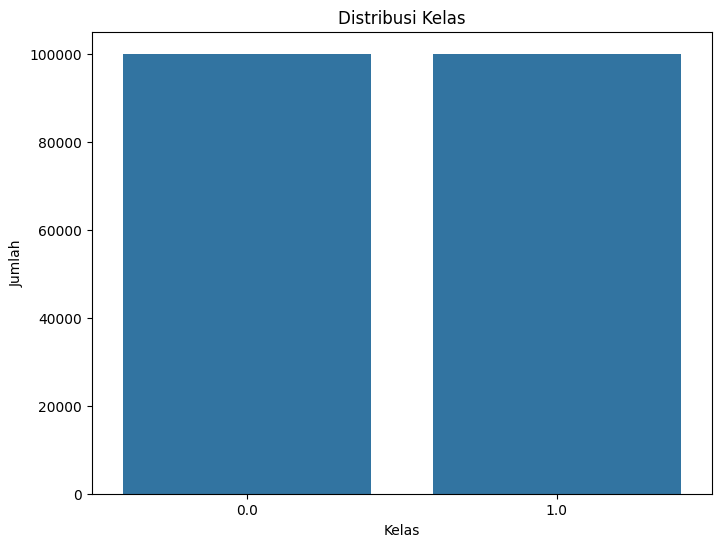

In [ ]:
# Visualisasi distribusi kelas
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Distribusi Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.show()

Model Transformer

In [ ]:
def build_transformer_model(input_dim, num_classes):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Reshape((input_dim, 1))(inputs)  # Reshape to sequence
    x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

Tuning Hyperparameter

In [ ]:
import tensorflow as tf
import keras_tuner as kt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Check and clean data for NaN or infinite values
if np.any(np.isnan(X_train)) or np.any(np.isinf(X_train)):
    X_train = np.nan_to_num(X_train)

if np.any(np.isnan(y_train)) or np.any(np.isinf(y_train)):
    y_train = np.nan_to_num(y_train)

# Normalize the data (if not already normalized)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Model-building function for Keras Tuner with Transformer architecture
def model_builder(hp):
    inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))

    # Reshape input for Transformer
    x = tf.keras.layers.Reshape((X_train.shape[1], 1))(inputs)

    # Tuning the number of transformer layers and the number of heads
    num_heads = hp.Int('num_heads', min_value=2, max_value=6, step=2)  # Reduce max heads
    key_dim = 32 // num_heads  # Make key_dim divisible by num_heads

    for i in range(hp.Int('num_layers', 1, 2)):  # Reduced layers to 1-2
        x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(units=hp.Int('units', min_value=64, max_value=128, step=32), activation='relu')(x)
    x = tf.keras.layers.Dropout(hp.Float('dropout', 0.2, 0.3, step=0.1))(x)  # Lower dropout
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 1e-3]), clipvalue=1.0),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

    return model

# Initialize Keras Tuner with a lower max_epochs to speed up search
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,  # Reduced epochs to speed up the search
                     factor=3,
                     directory='my_dir',
                     project_name='ddos_detection')

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience

# Perform the hyperparameter tuning
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)





Trial 33 Complete [00h 00m 46s]
val_accuracy: 0.879156231880188

Best val_accuracy So Far: 0.8830000162124634
Total elapsed time: 00h 20m 27s


K-Fold

In [ ]:
from sklearn.metrics import f1_score, recall_score

kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
recalls = []
f1_scores = []
losses = []
history_list = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the best model on the current fold
    history = best_model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=1)
    history_list.append(history)

    # Evaluate the model
    scores = best_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    y_pred = best_model.predict(X_val_fold) > 0.5  # Predictions with threshold of 0.5

    # Calculate metrics
    accuracies.append(scores[1] * 100)  # Accuracy
    recalls.append(recall_score(y_val_fold, y_pred))  # Recall
    f1_scores.append(f1_score(y_val_fold, y_pred))  # F1 Score
    losses.append(scores[0])  # Loss

    # Print fold metrics including F1 Score
    print(f'Fold {fold_no} - Accuracy: {scores[1]*100:.2f}%, Recall: {recalls[-1]*100:.2f}%, F1 Score: {f1_scores[-1]*100:.2f}%, Loss: {scores[0]:.4f}')
    fold_no += 1

# Print the average metrics after all folds
print(f'Mean accuracy over folds: {np.mean(accuracies):.2f}%')
print(f'Mean recall over folds: {np.mean(recalls):.2f}%')
print(f'Mean F1 Score over folds: {np.mean(f1_scores):.2f}%')
print(f'Mean loss over folds: {np.mean(losses):.4f}')


Epoch 1/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8852 - loss: 0.2736 - recall_3: 0.8883 - val_accuracy: 0.8892 - val_loss: 0.2656 - val_recall_3: 0.9202
Epoch 2/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8853 - loss: 0.2730 - recall_3: 0.8865 - val_accuracy: 0.8898 - val_loss: 0.2635 - val_recall_3: 0.9236
Epoch 3/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8864 - loss: 0.2731 - recall_3: 0.8887 - val_accuracy: 0.8906 - val_loss: 0.2598 - val_recall_3: 0.9254
Epoch 4/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8854 - loss: 0.2742 - recall_3: 0.8883 - val_accuracy: 0.8849 - val_loss: 0.2732 - val_recall_3: 0.8939
Epoch 5/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8866 - loss: 0.2717 - recall_3: 0.8891 - val_accuracy: 0.8841 - val_loss: 0.2630 - val_recall_3: 0.9019
Epoch 6/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8851 - loss: 0.2752 - recall_3: 0.8888 - val_accuracy: 0.8886 - va

Visualisasi Epoch

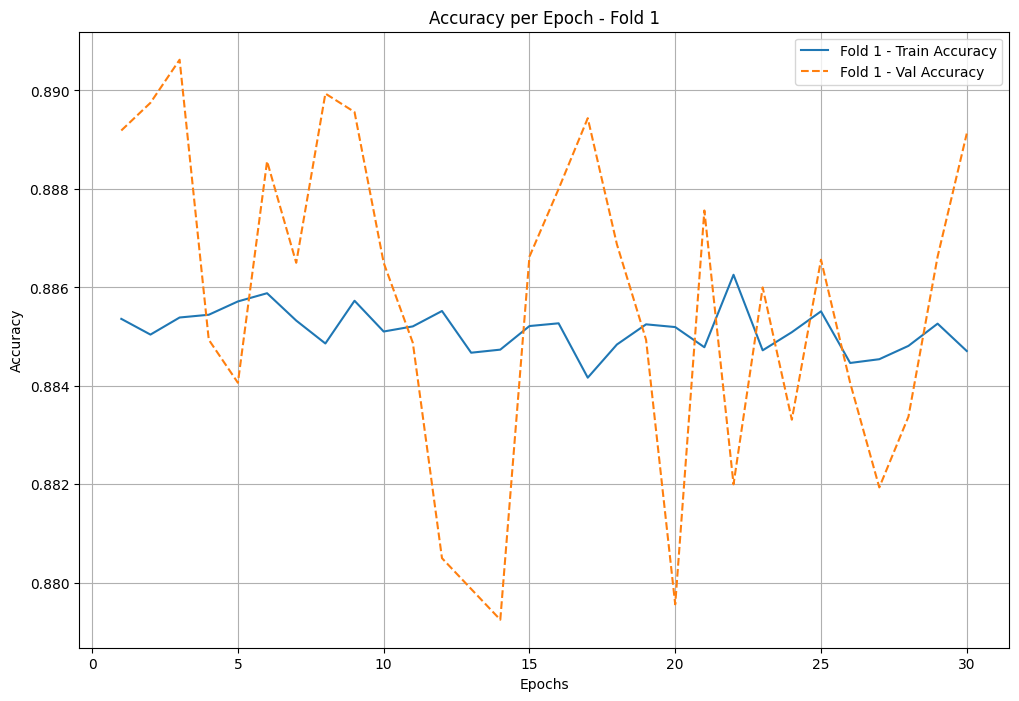

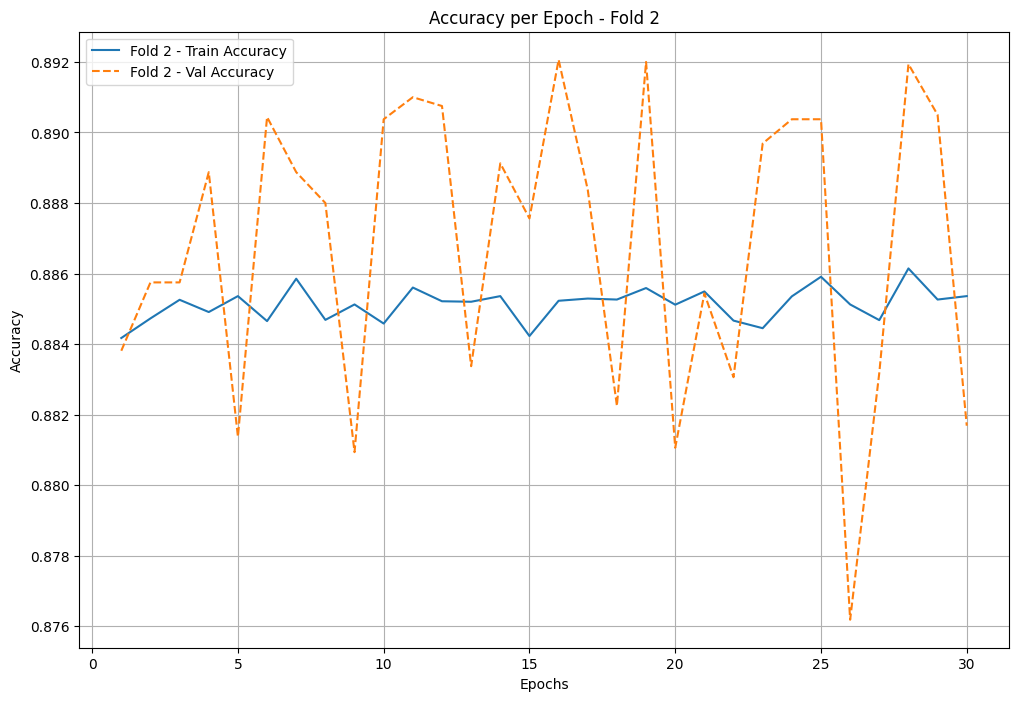

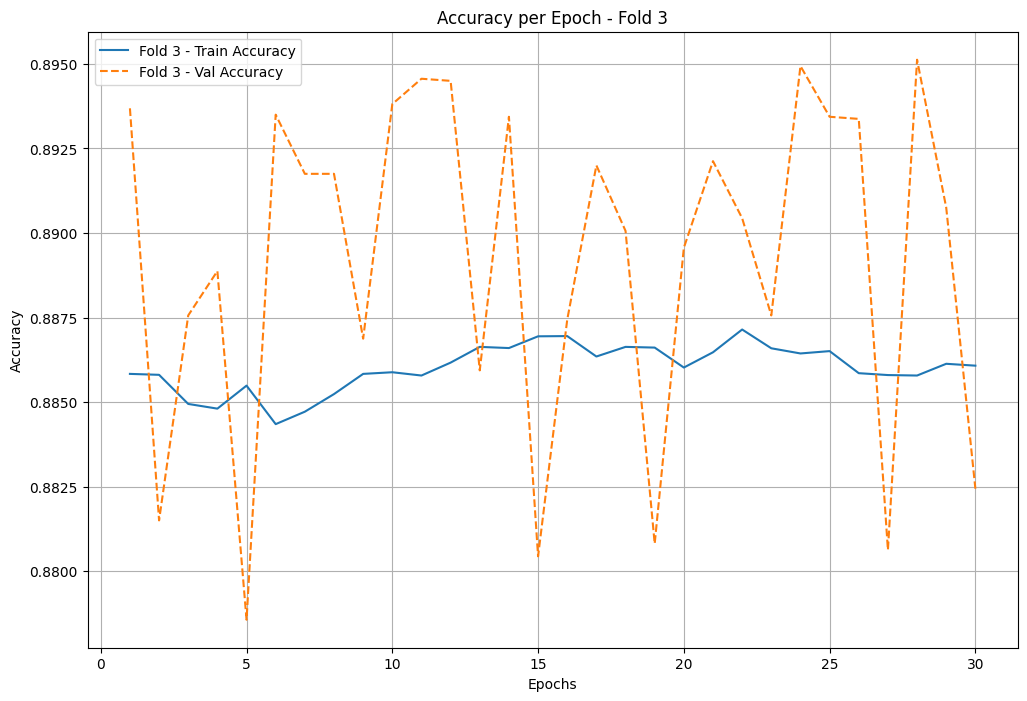

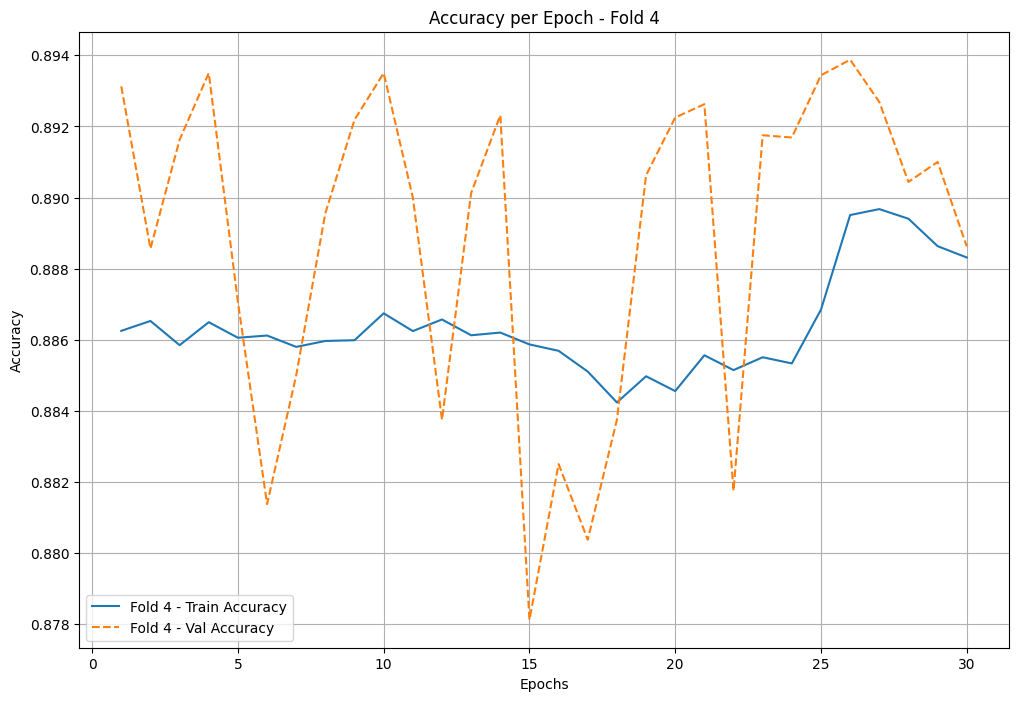

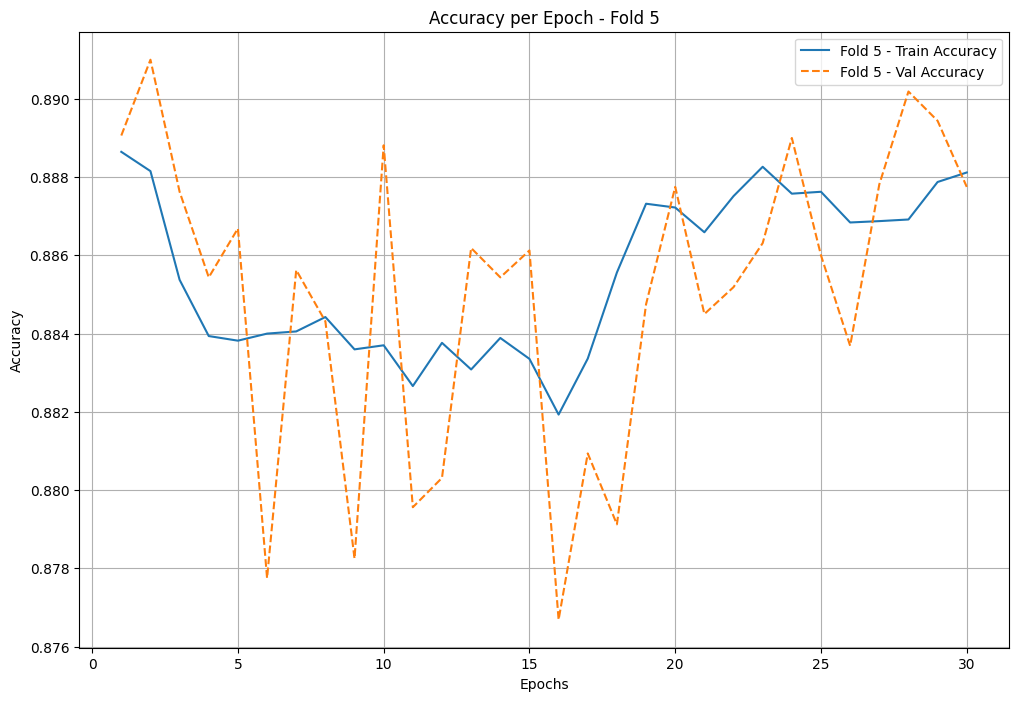

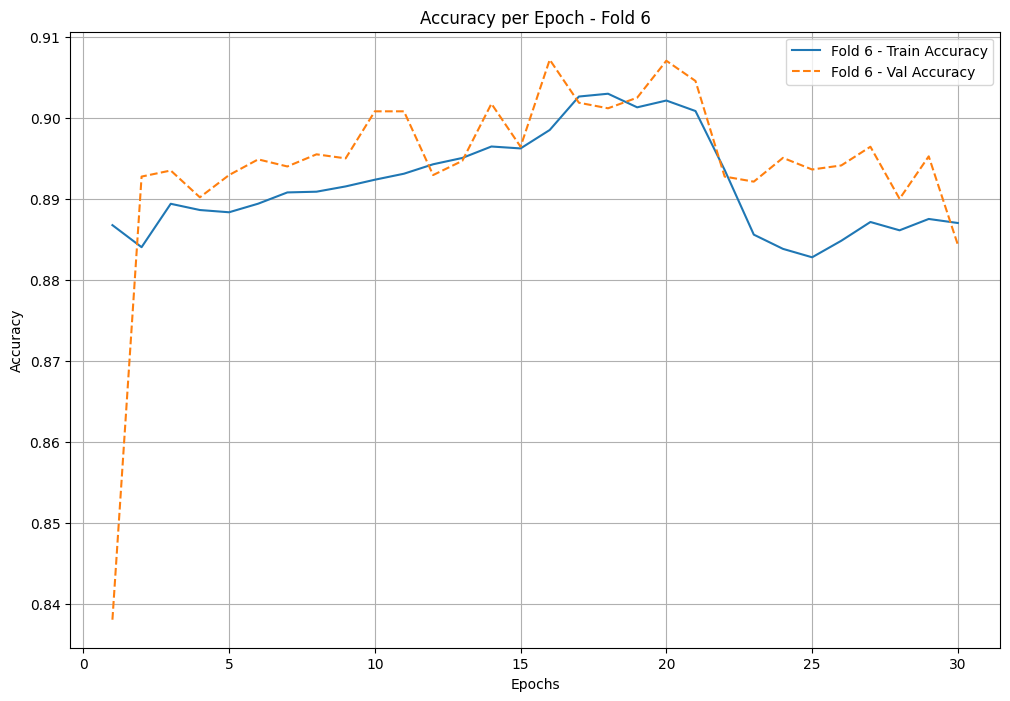

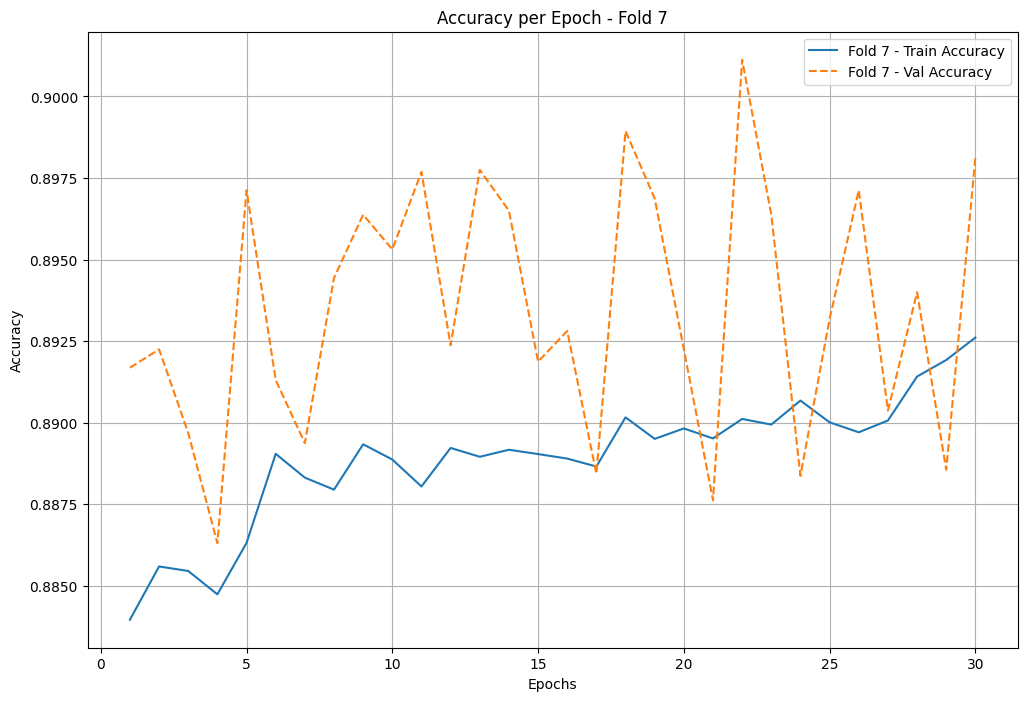

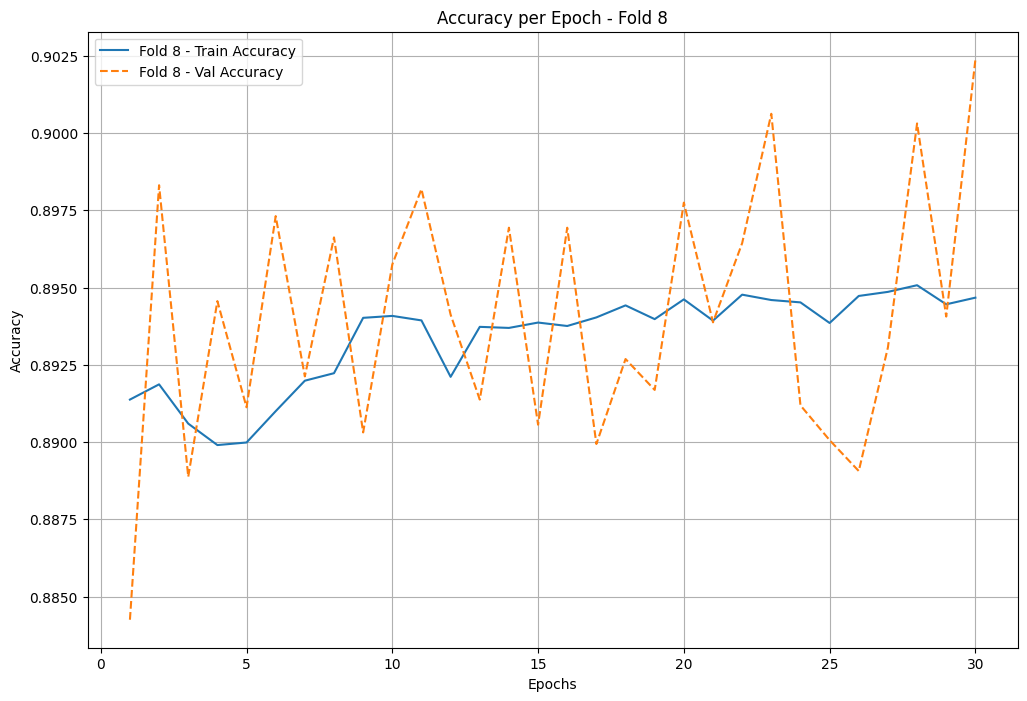

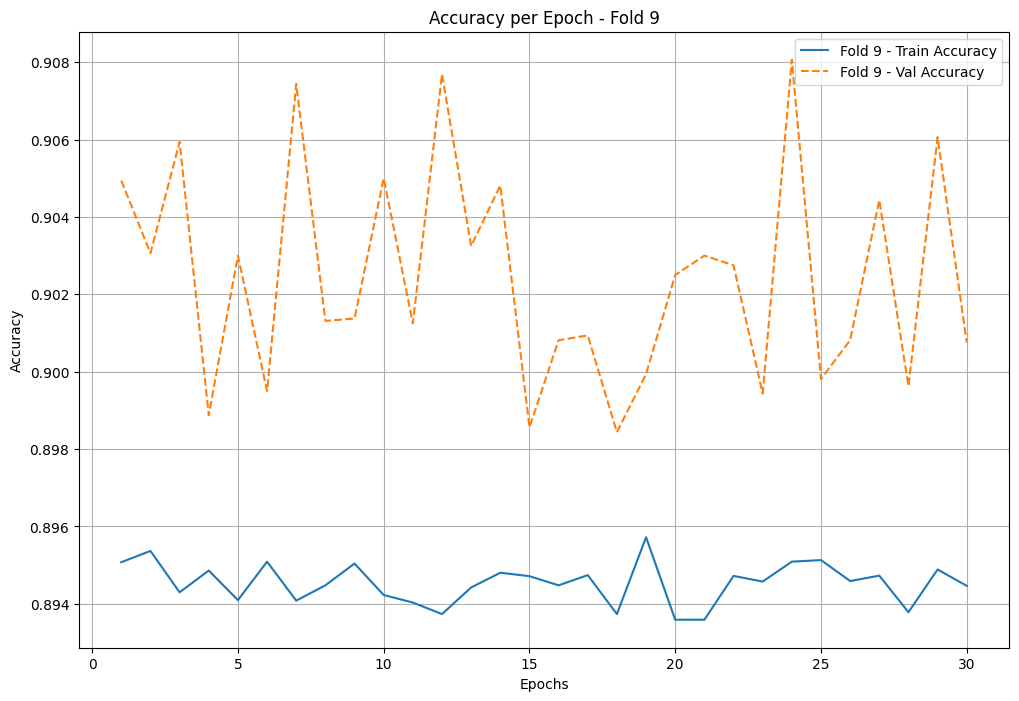

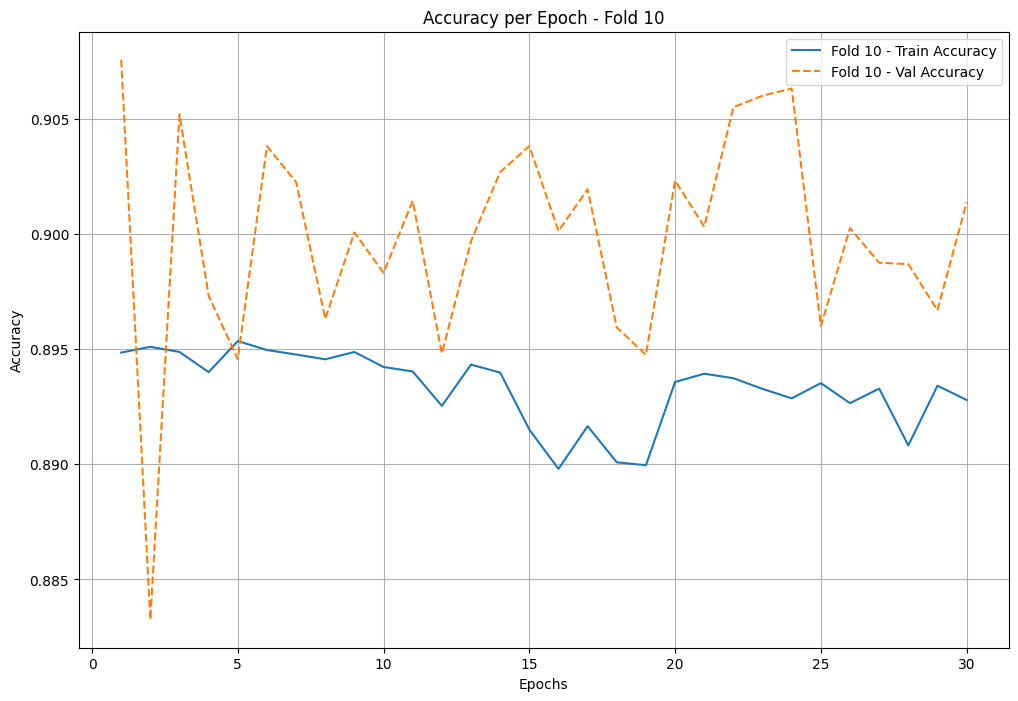

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


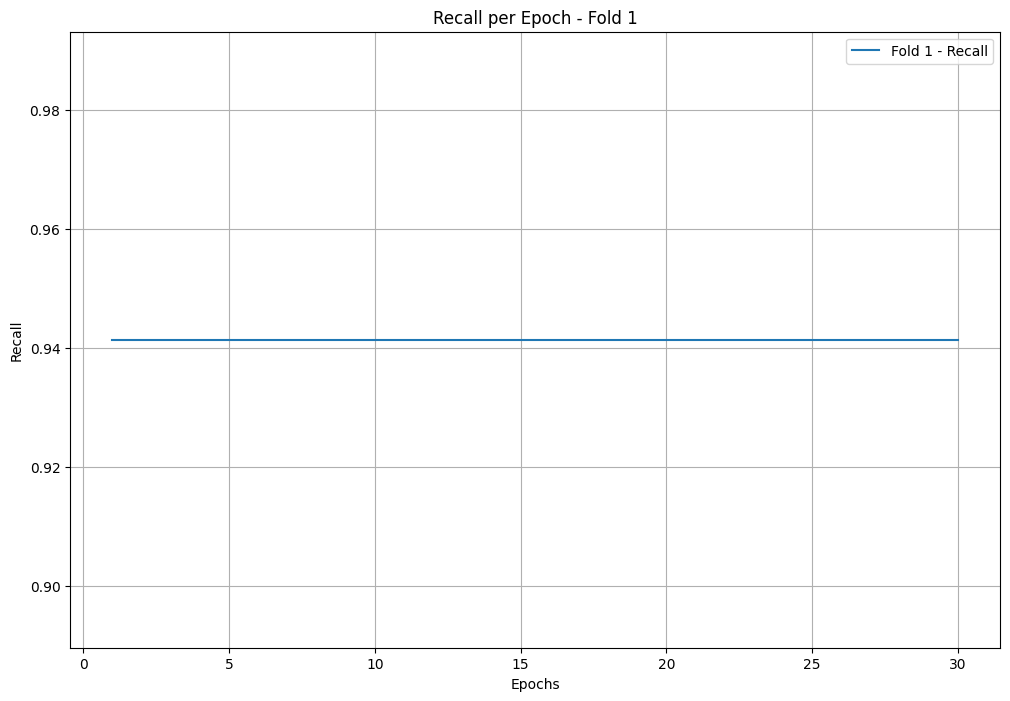

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


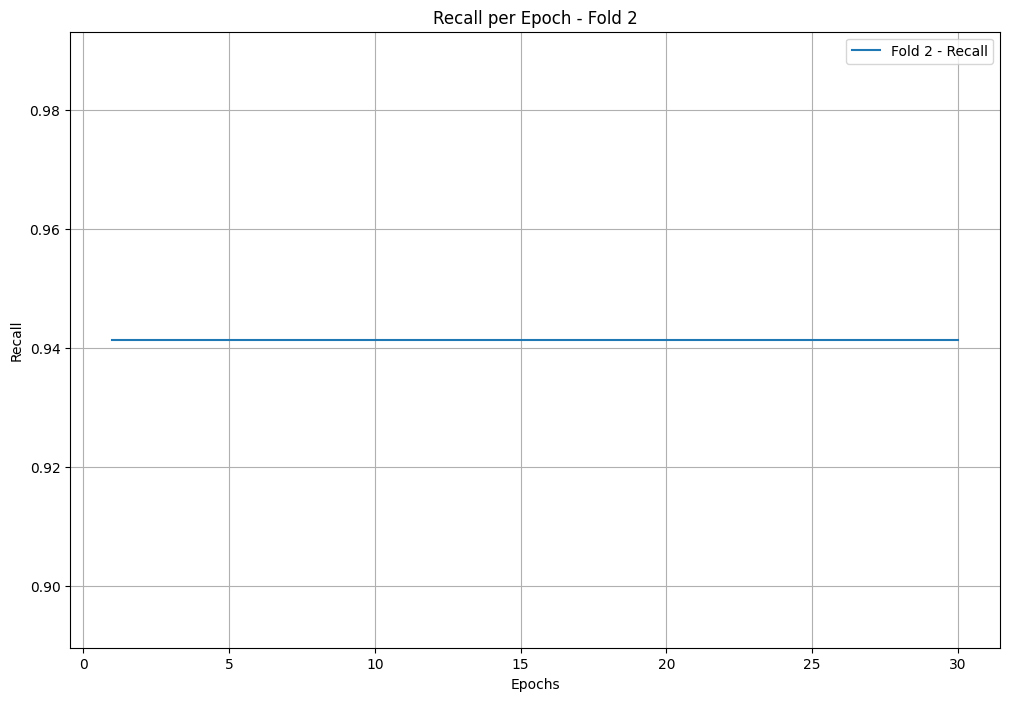

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


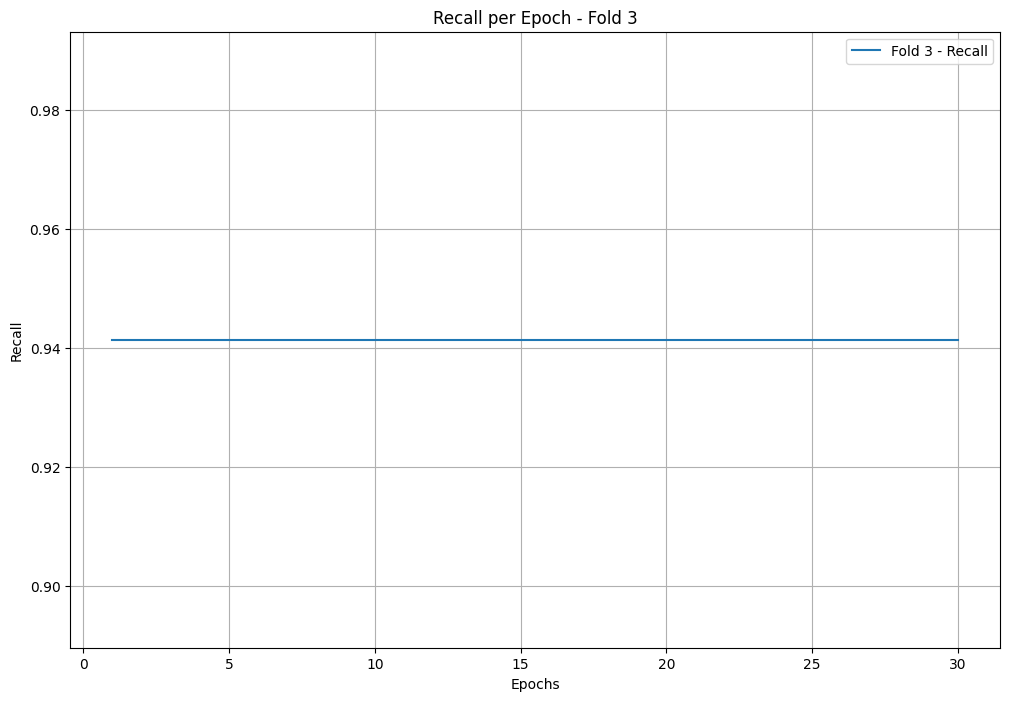

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


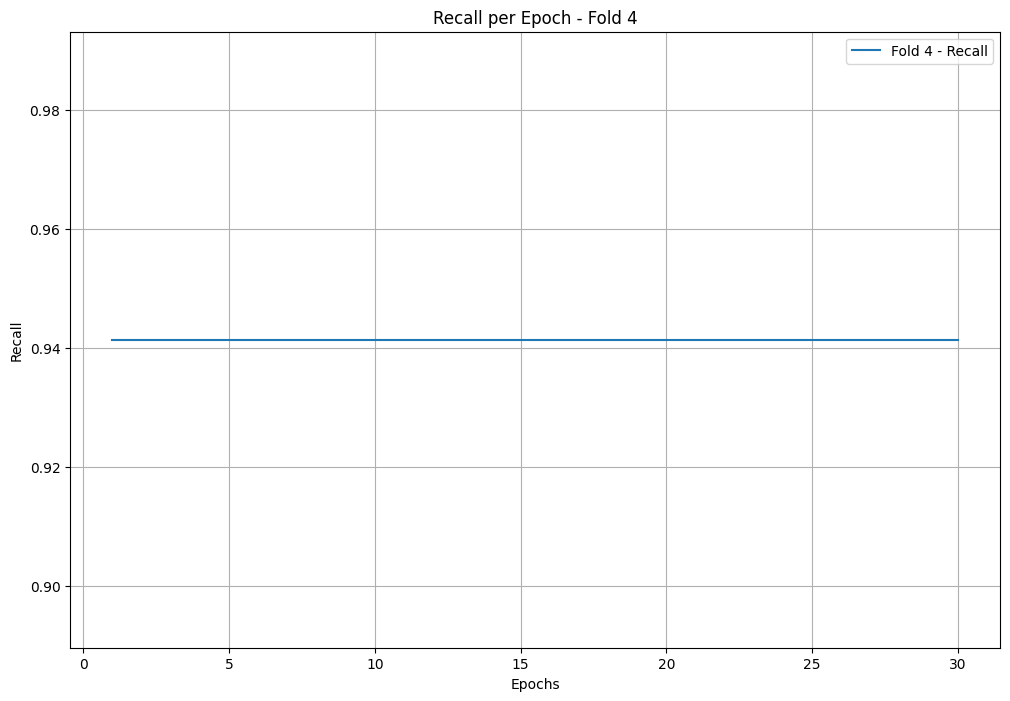

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


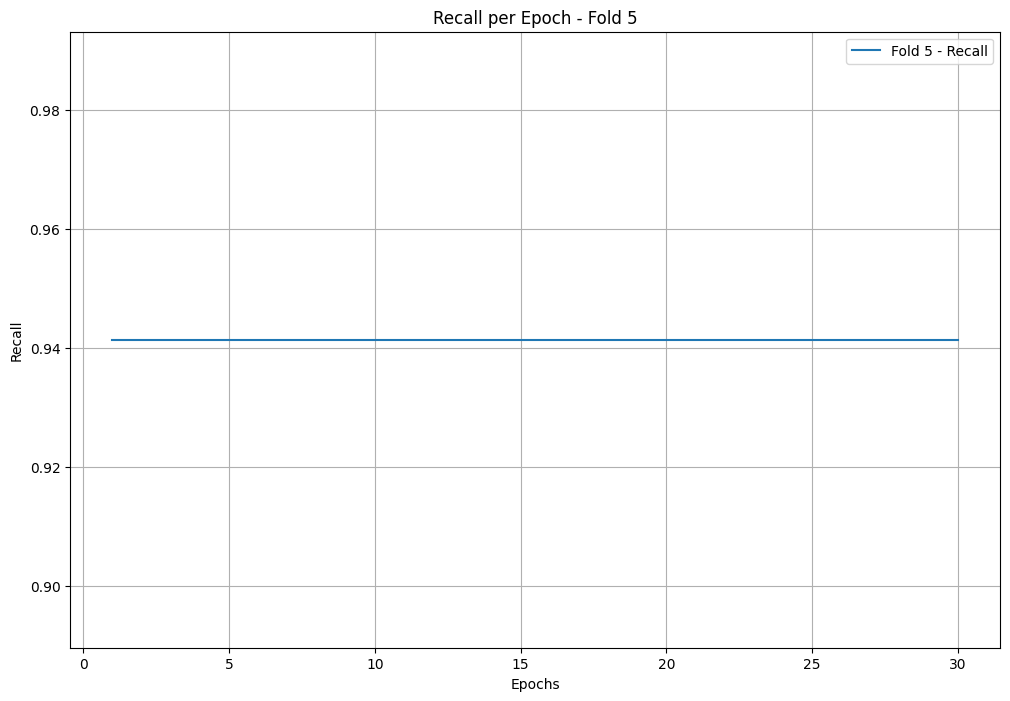

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


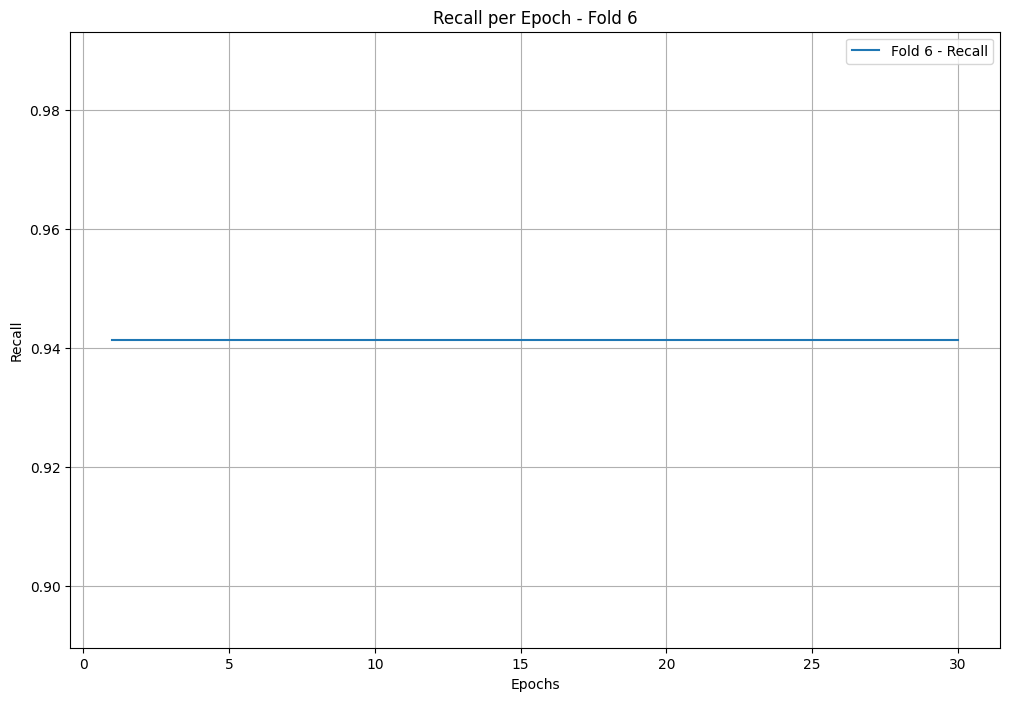

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


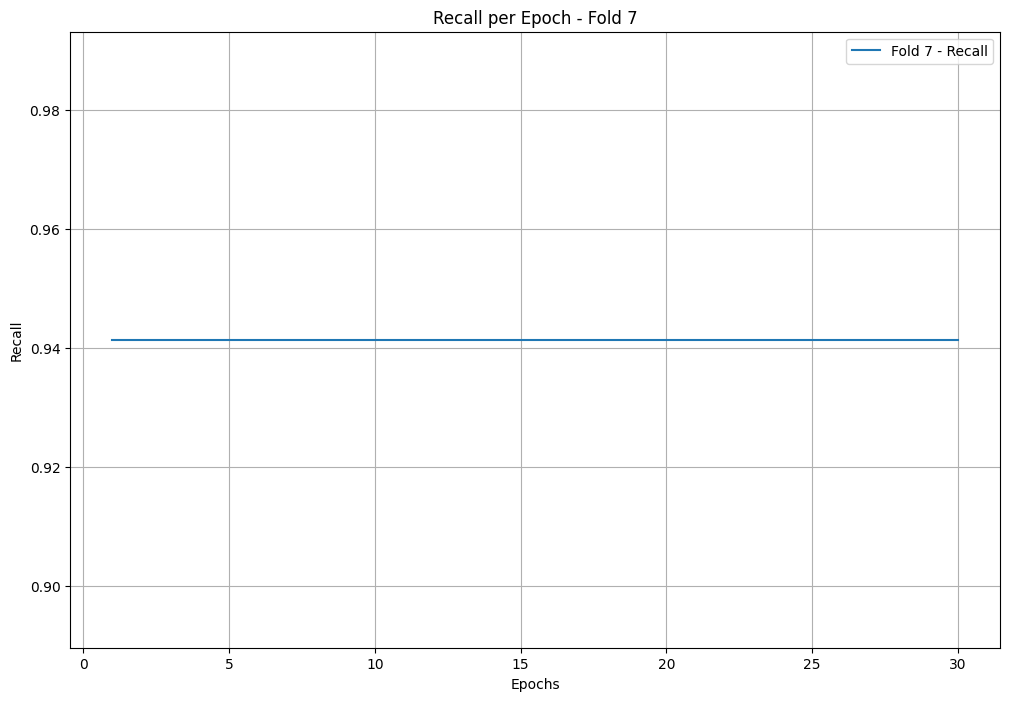

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


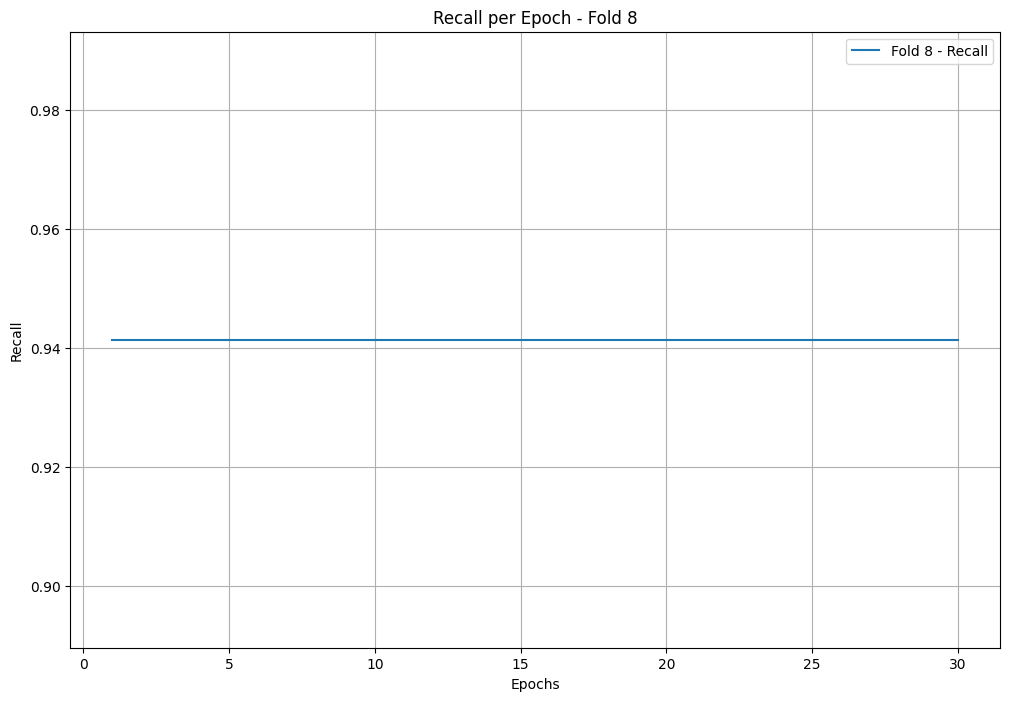

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


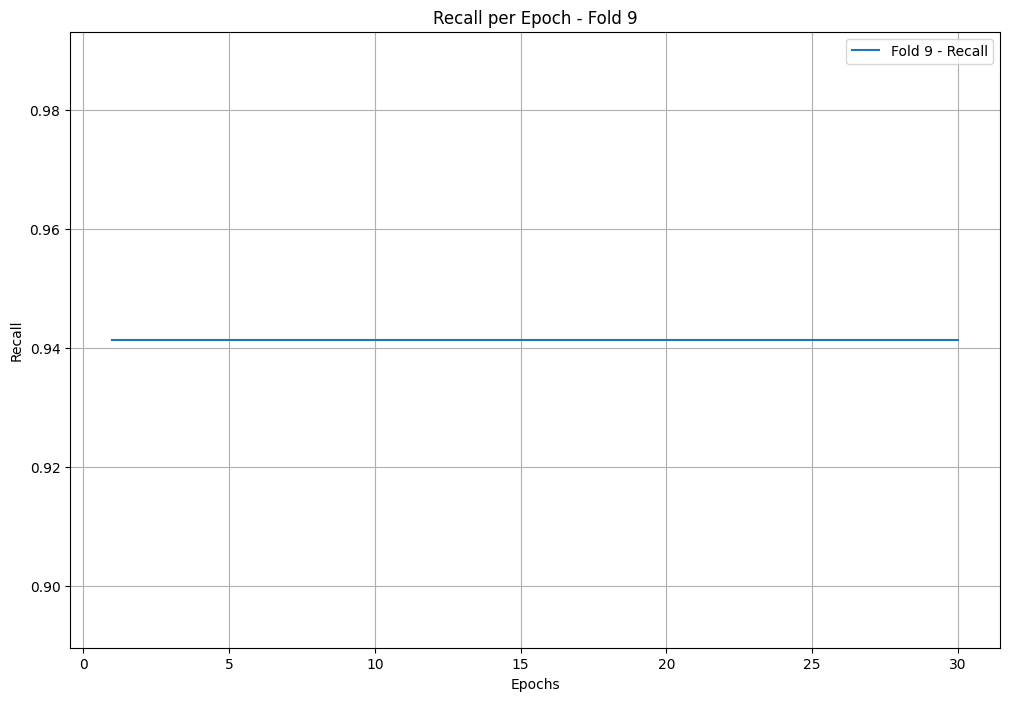

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


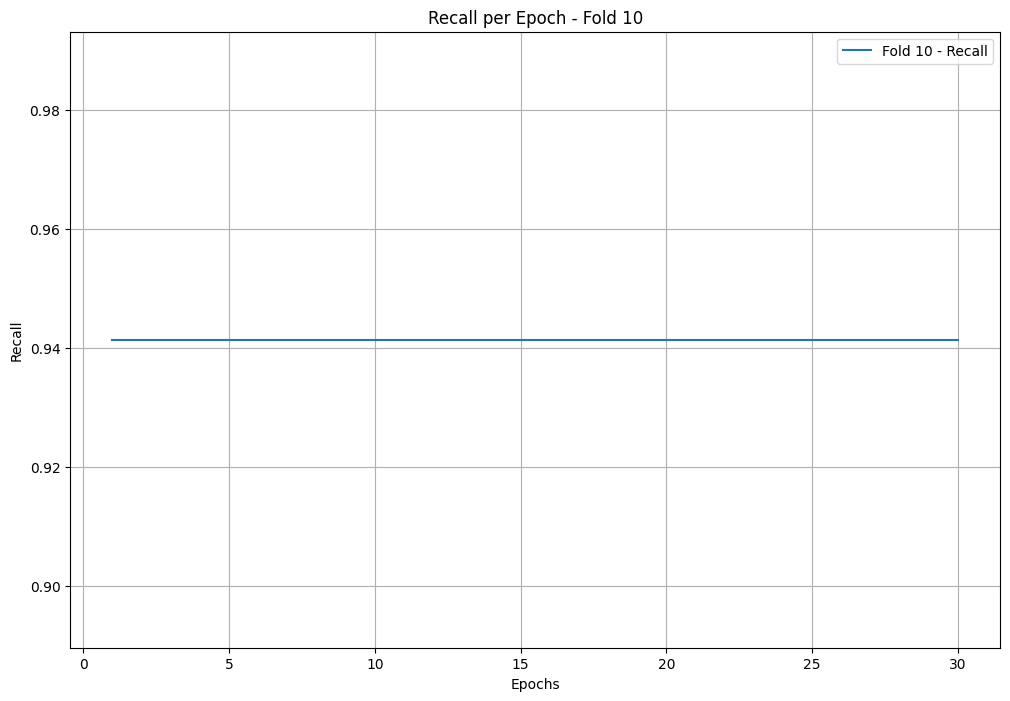

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


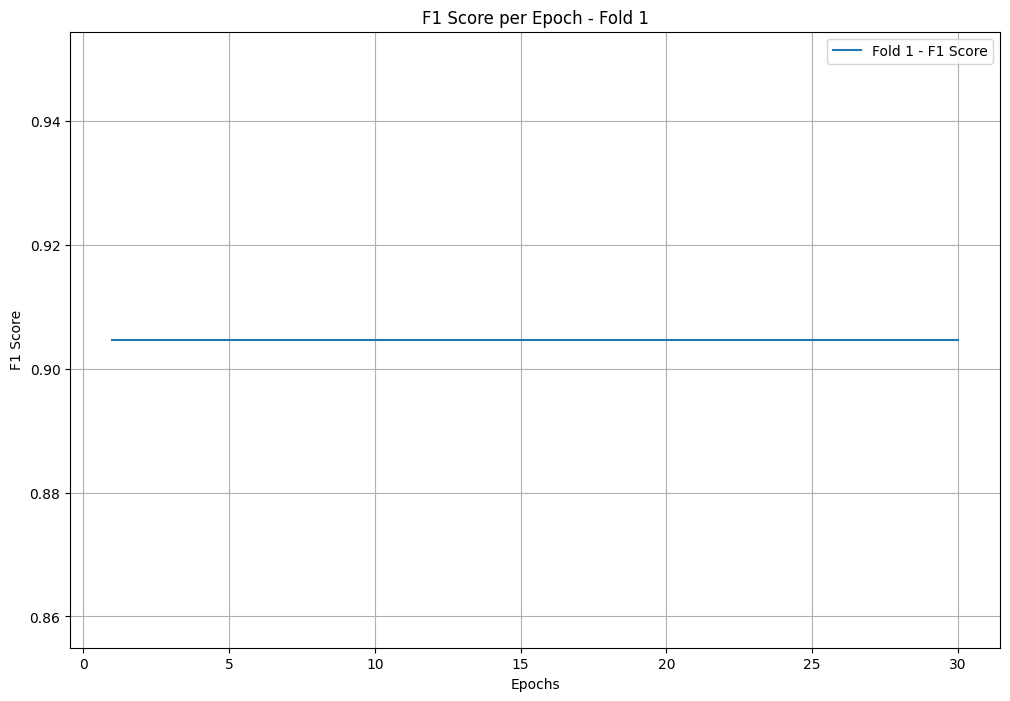

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


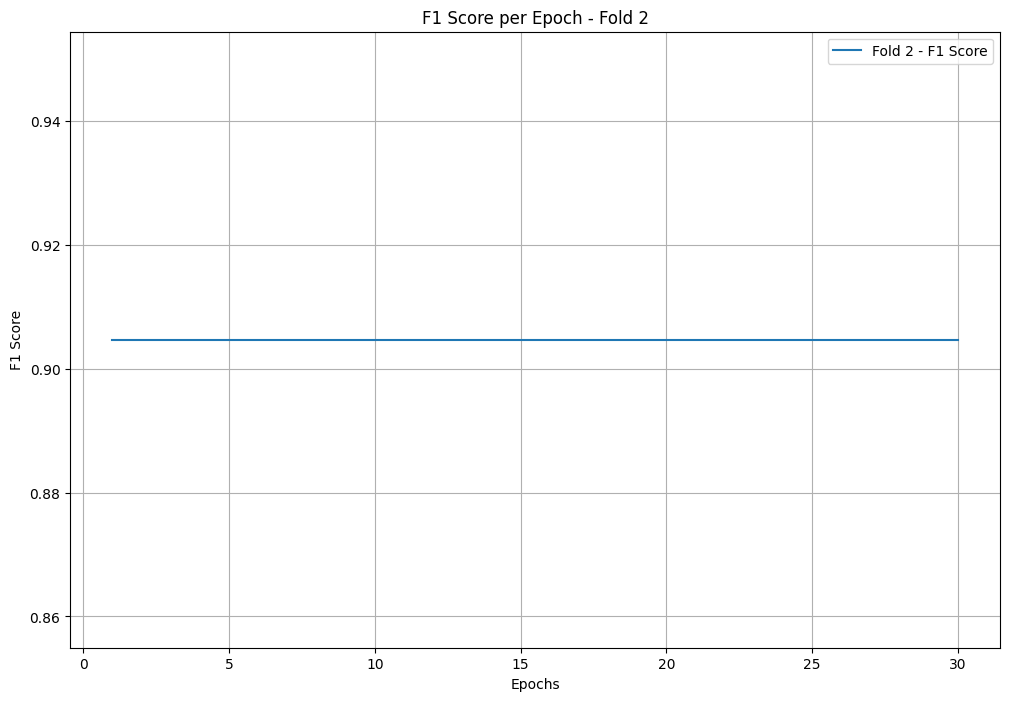

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


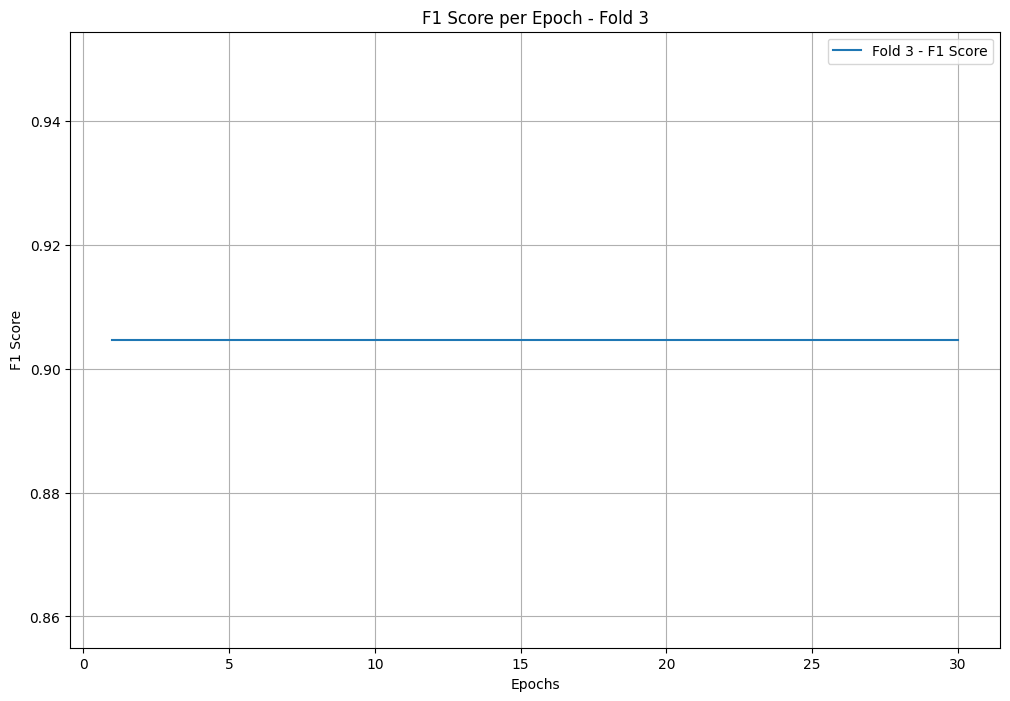

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


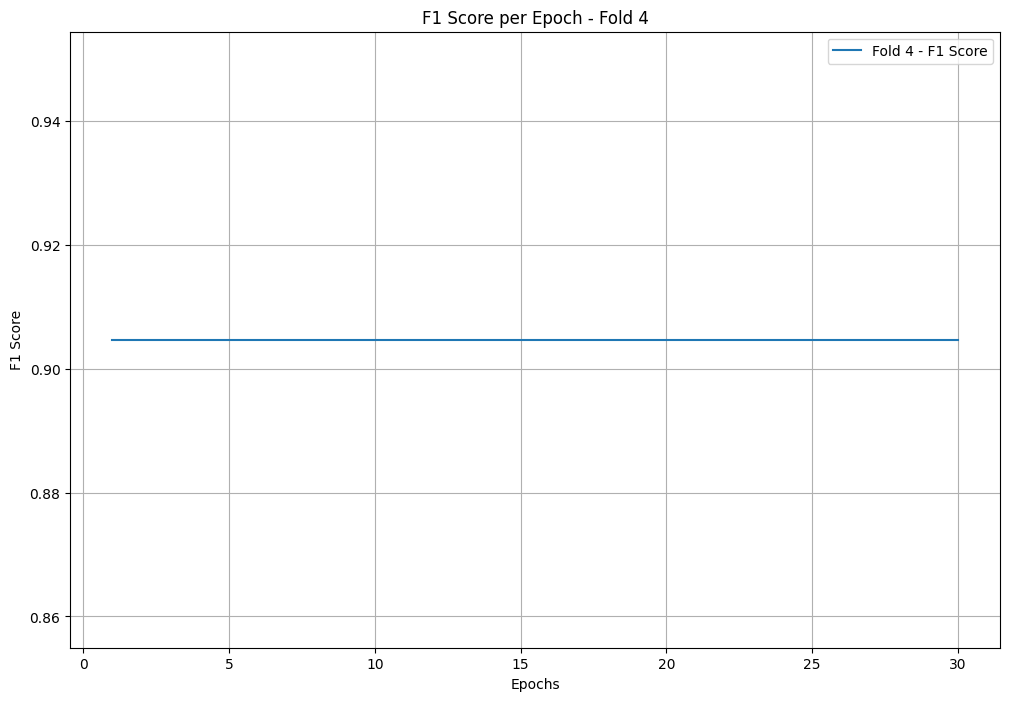

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


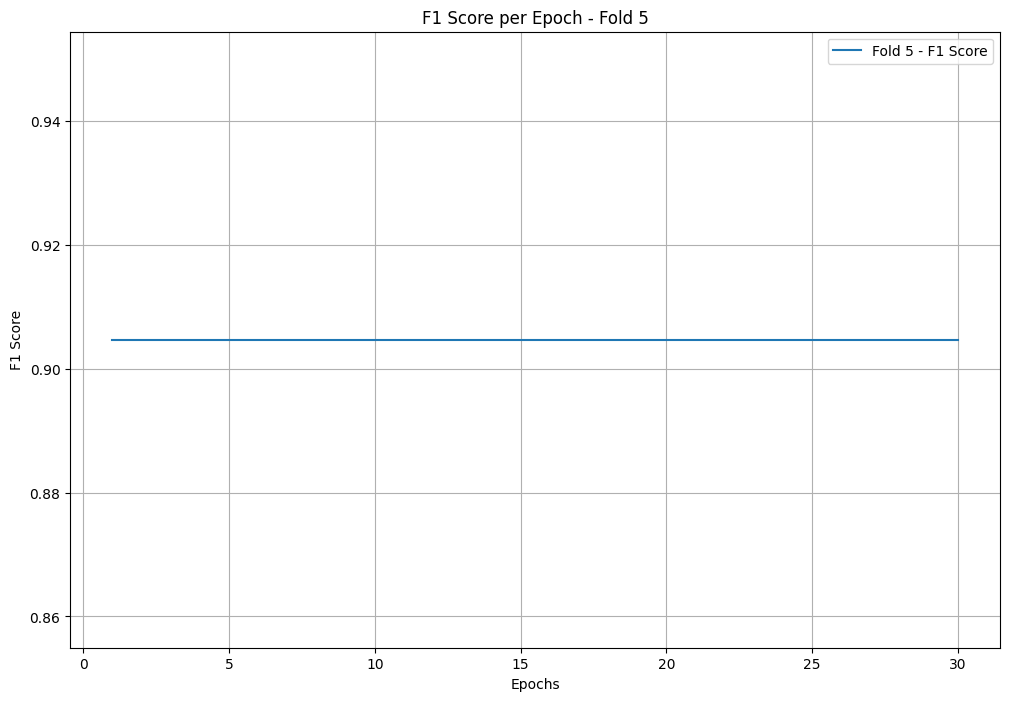

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


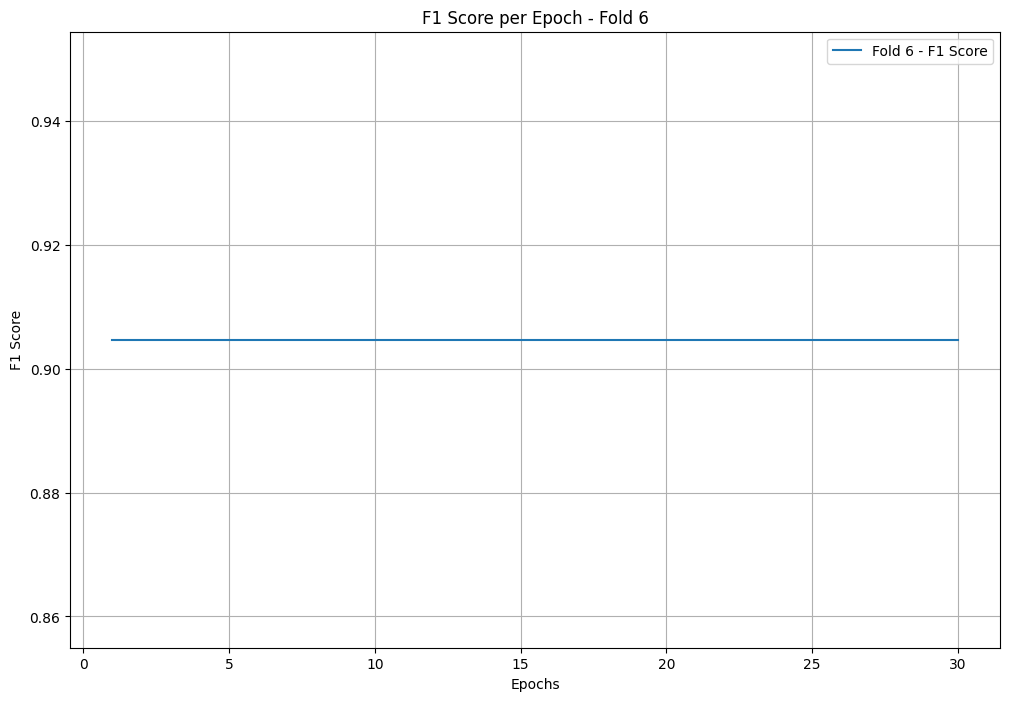

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


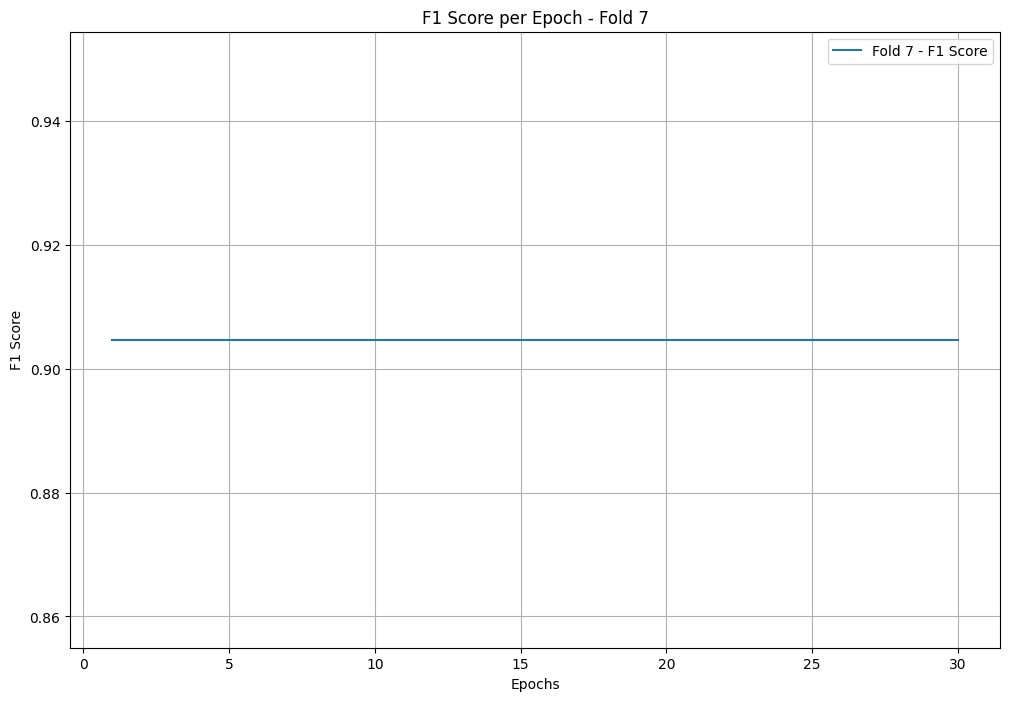

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


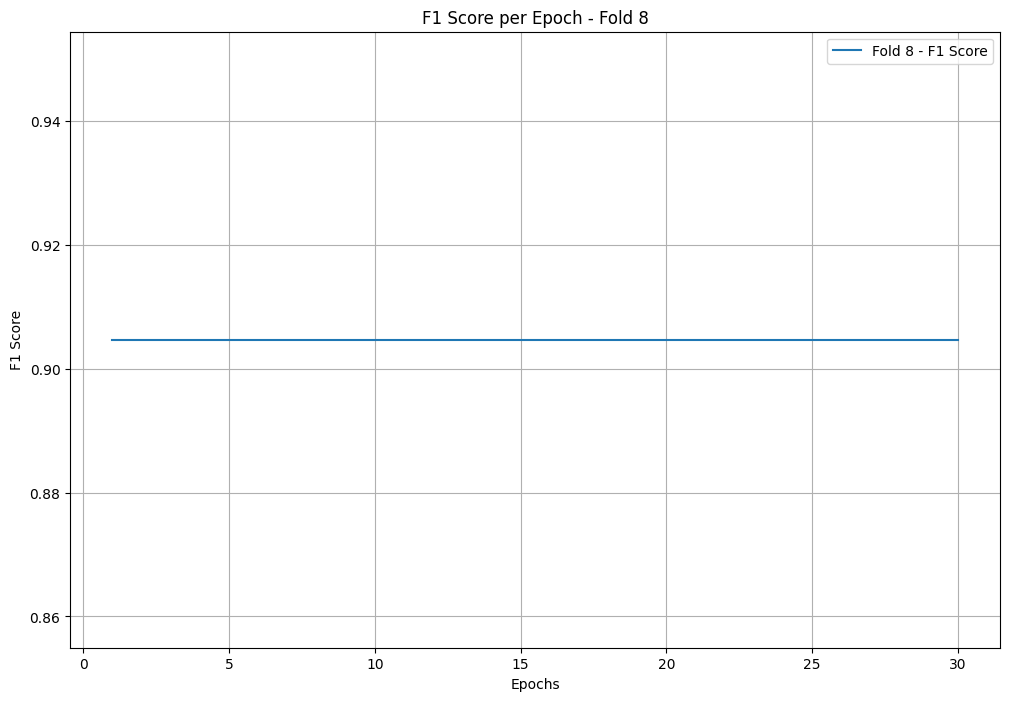

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


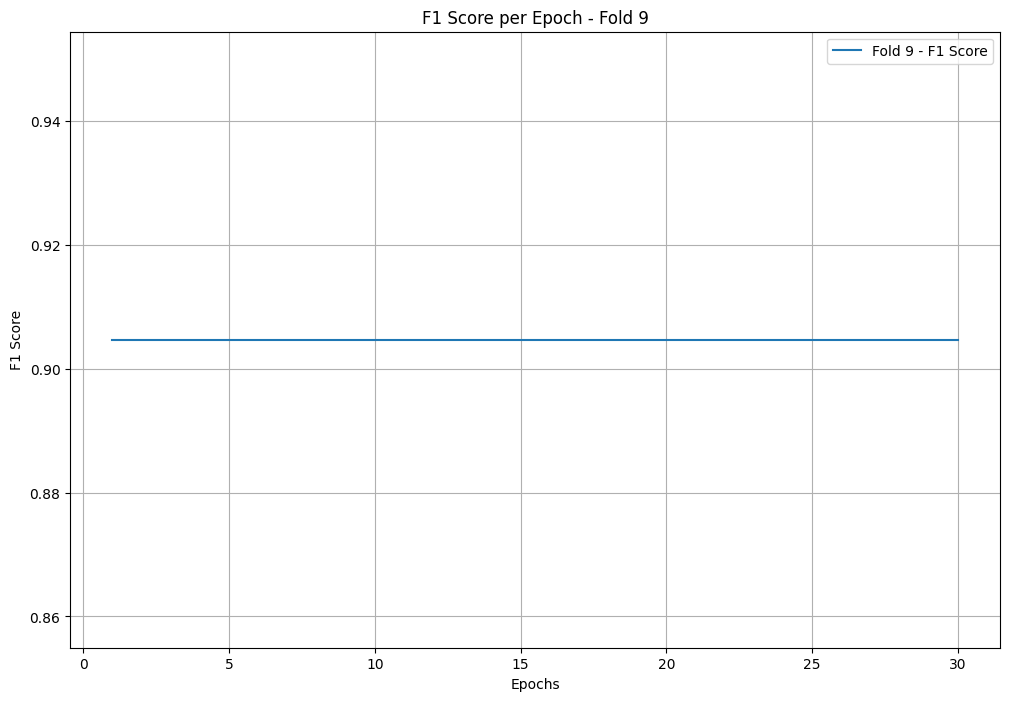

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


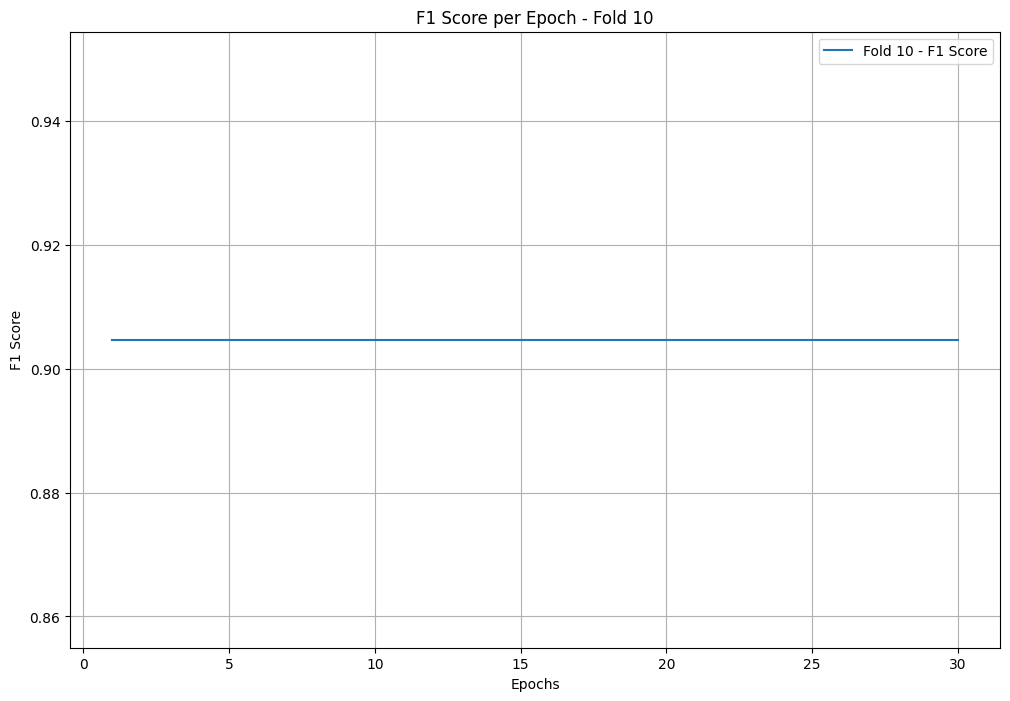

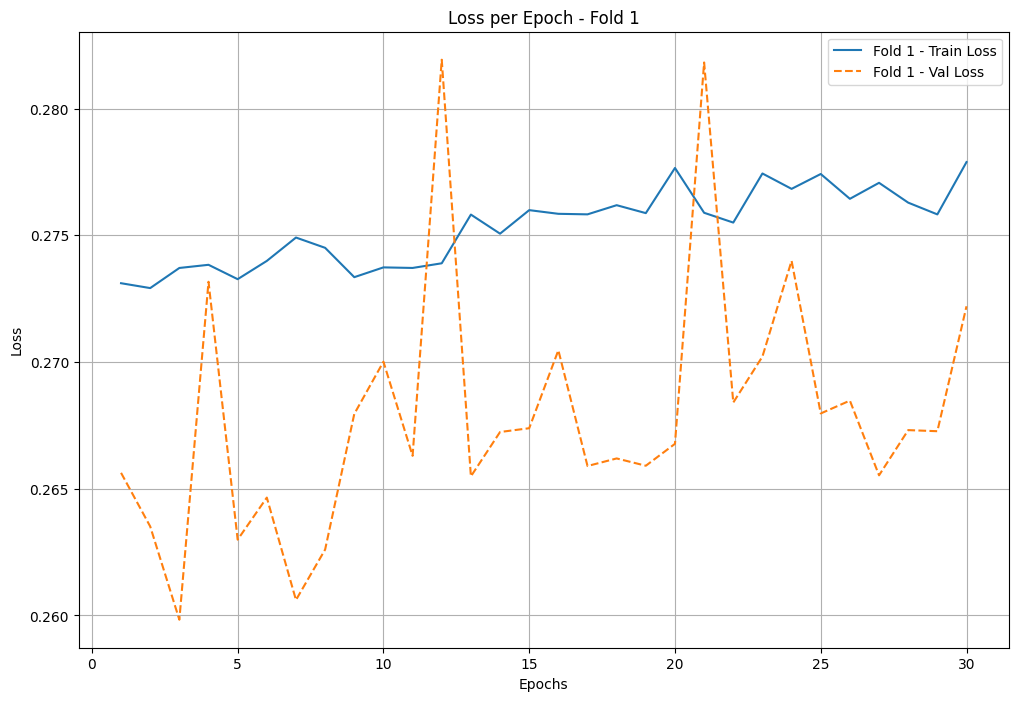

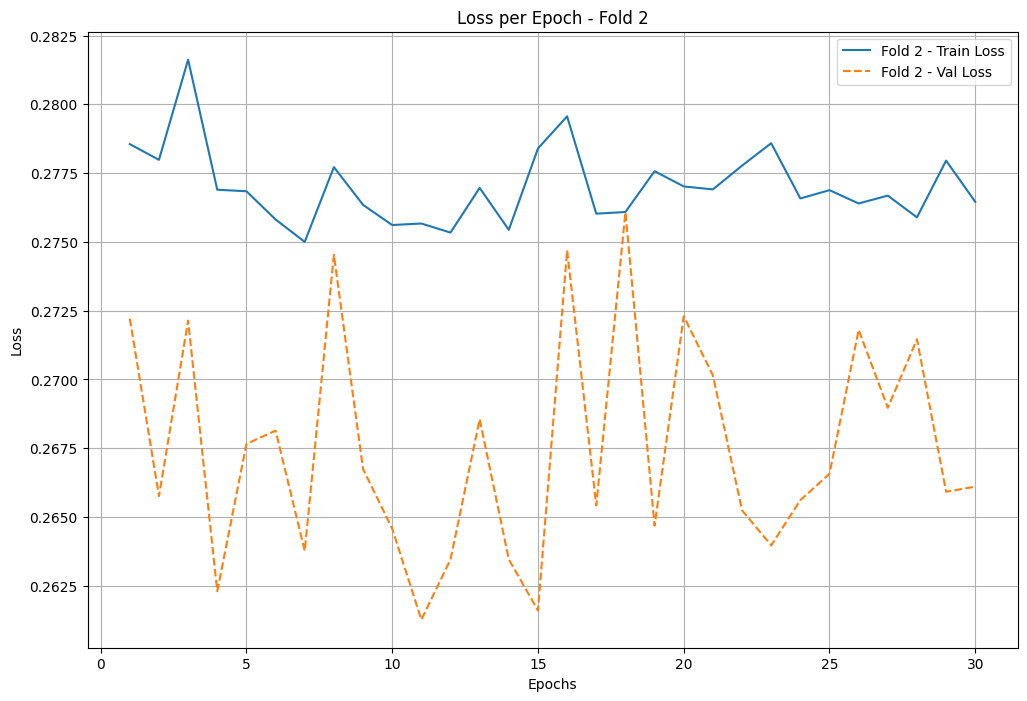

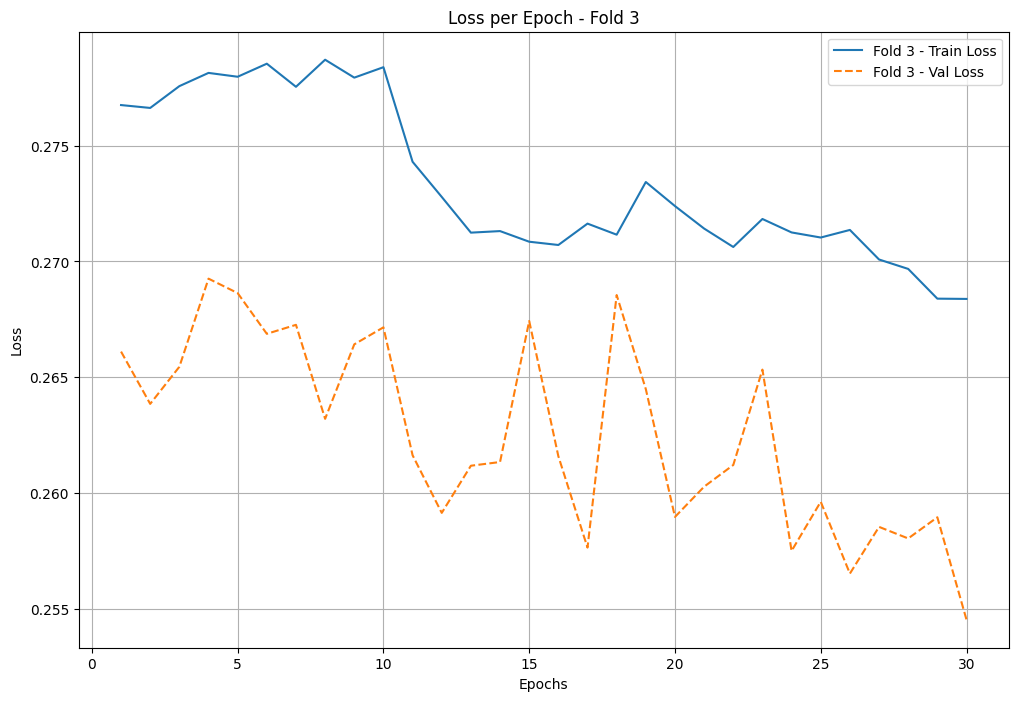

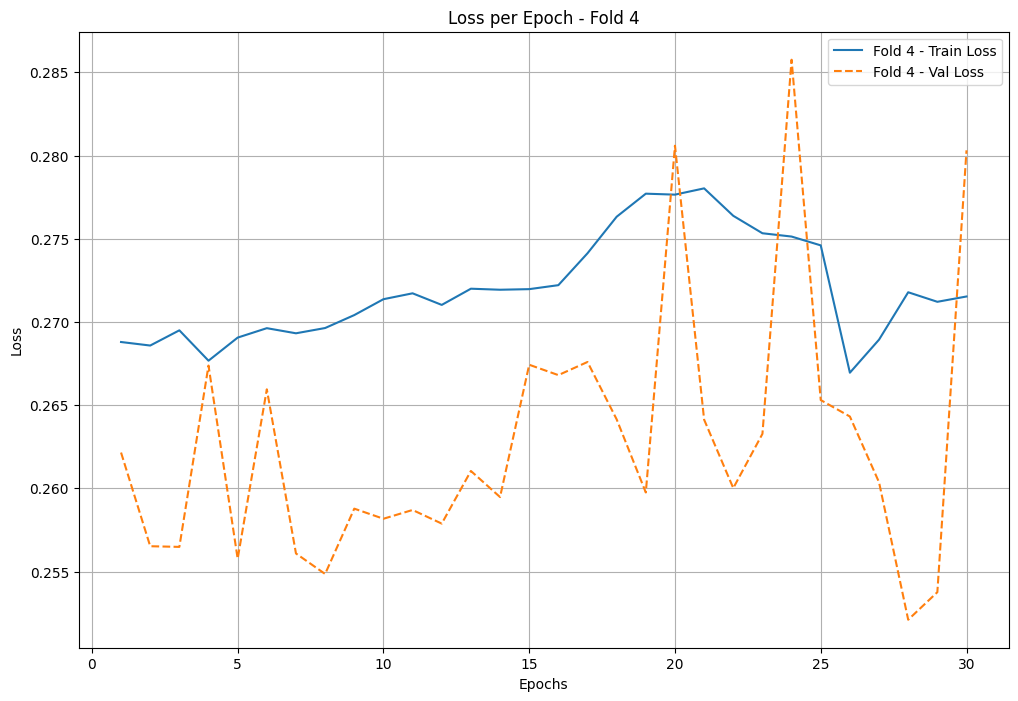

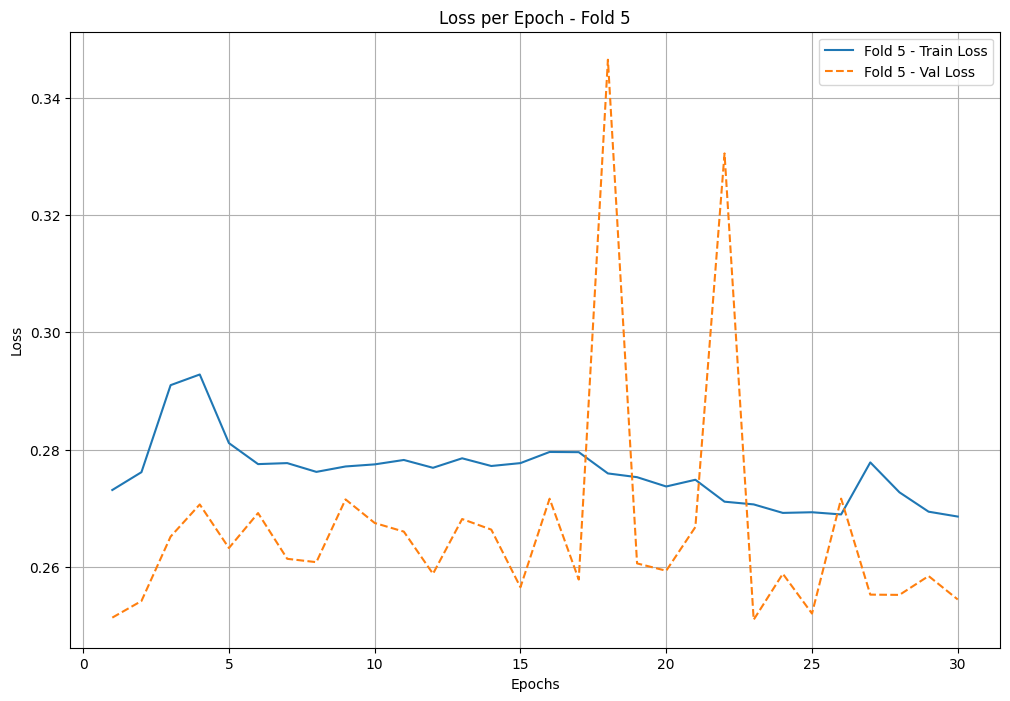

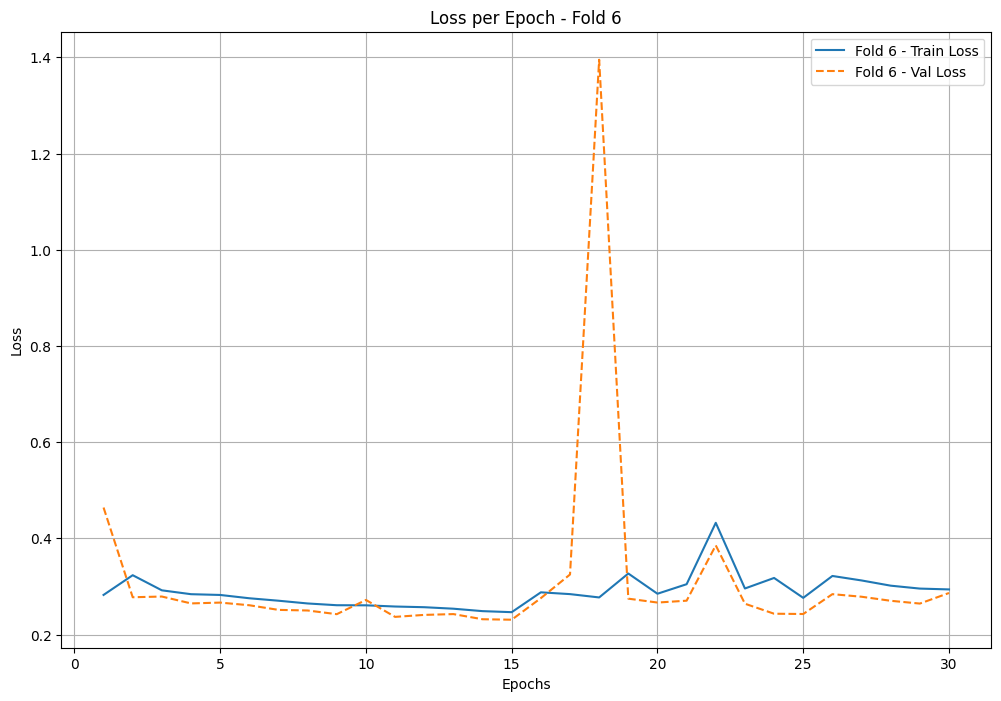

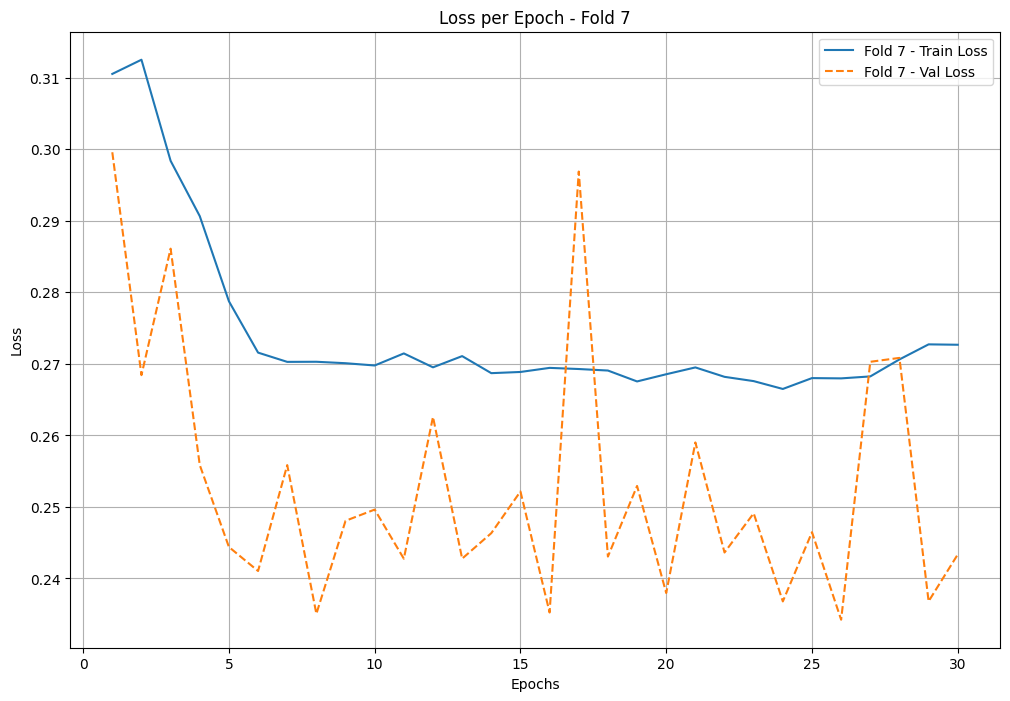

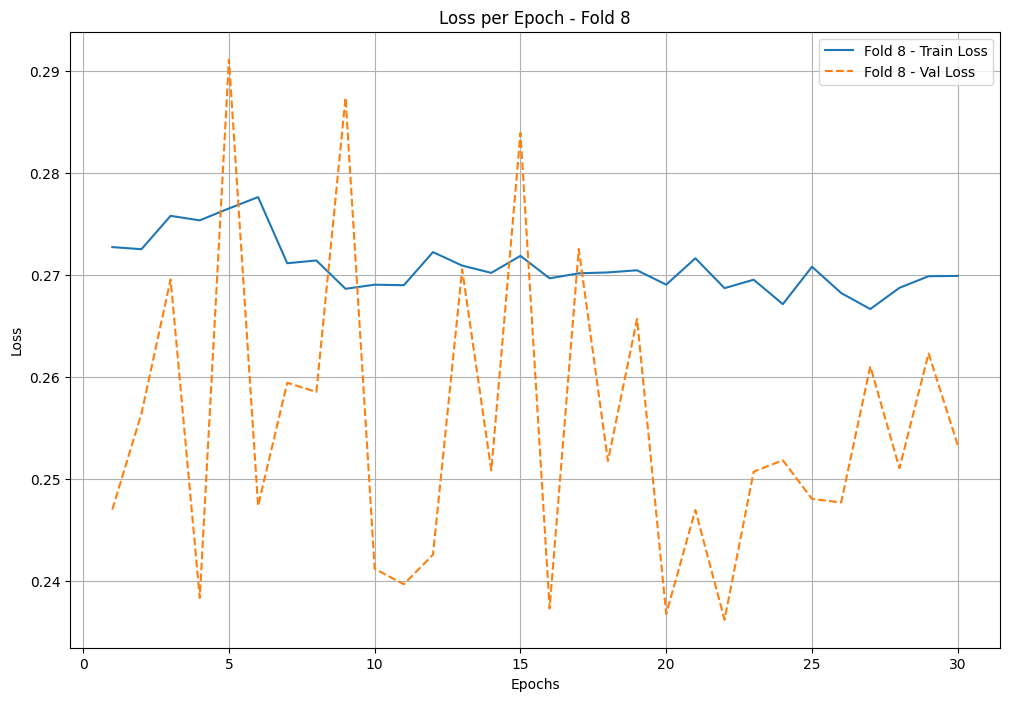

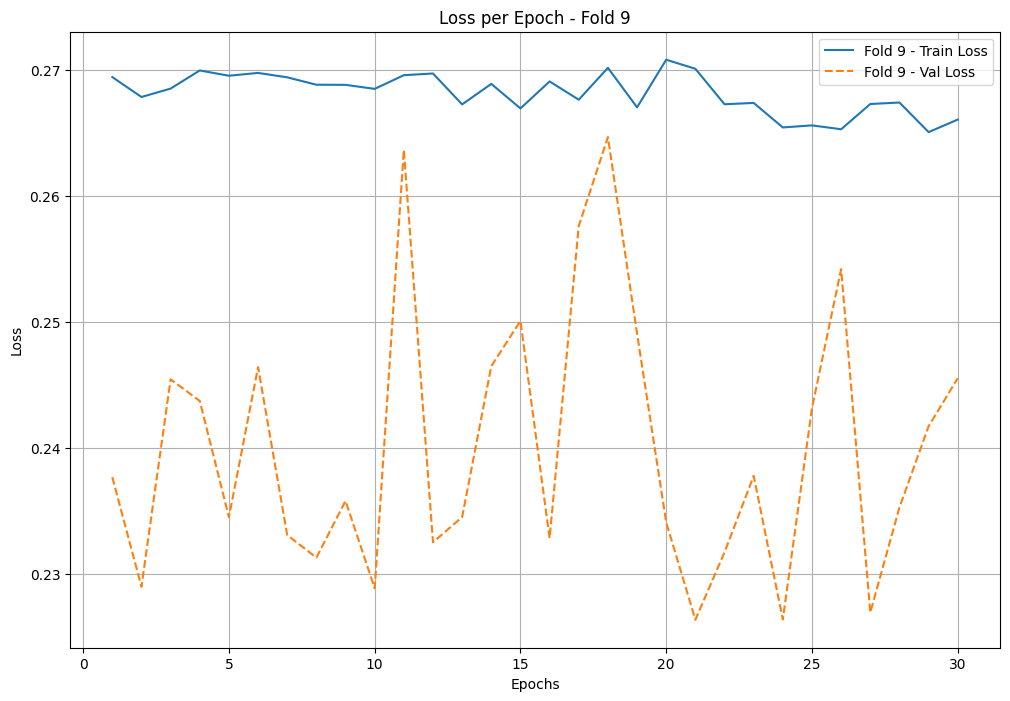

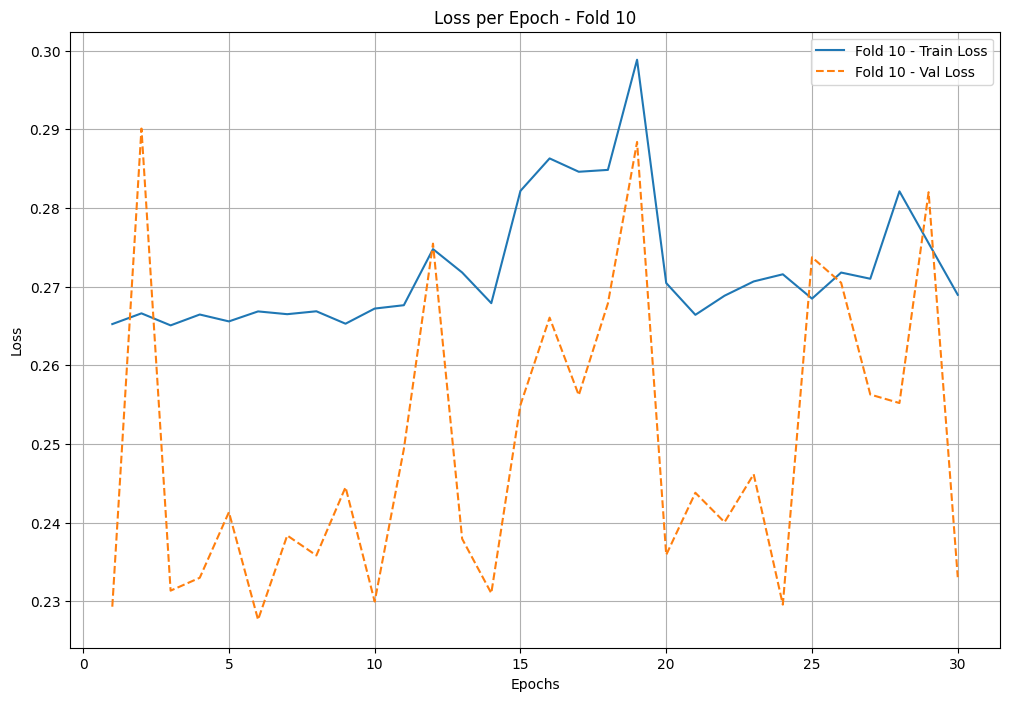

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 31)  # Karena epoch yang digunakan adalah 30

# Visualisasi per fold untuk akurasi
for fold_no, history in enumerate(history_list, start=1):
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history.history['accuracy'], label=f'Fold {fold_no} - Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label=f'Fold {fold_no} - Val Accuracy', linestyle='--')

    plt.title(f'Accuracy per Epoch - Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualisasi per fold untuk recall
for fold_no, history in enumerate(history_list, start=1):
    val_recall = recall_score(y_val_fold, (best_model.predict(X_val_fold) > 0.5))
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, [val_recall] * len(epochs), label=f'Fold {fold_no} - Recall')

    plt.title(f'Recall per Epoch - Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualisasi per fold untuk f1 score
for fold_no, history in enumerate(history_list, start=1):
    val_f1 = f1_score(y_val_fold, (best_model.predict(X_val_fold) > 0.5))
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, [val_f1] * len(epochs), label=f'Fold {fold_no} - F1 Score')

    plt.title(f'F1 Score per Epoch - Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualisasi per fold untuk loss
for fold_no, history in enumerate(history_list, start=1):
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history.history['loss'], label=f'Fold {fold_no} - Train Loss')
    plt.plot(epochs, history.history['val_loss'], label=f'Fold {fold_no} - Val Loss', linestyle='--')

    plt.title(f'Loss per Epoch - Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Visualisasi Fold

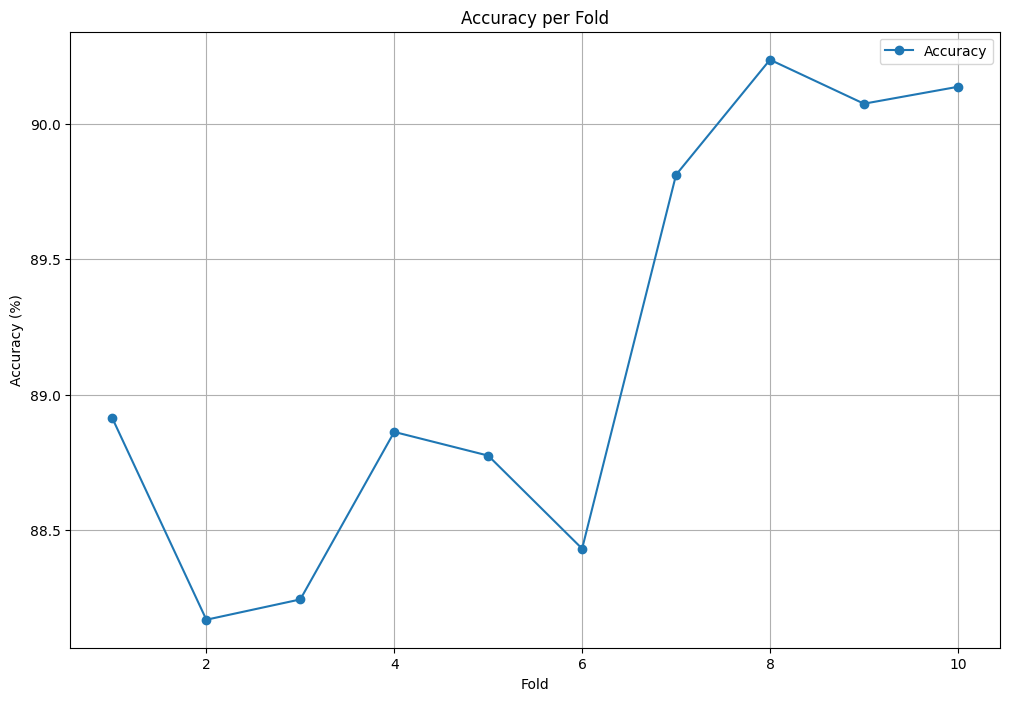

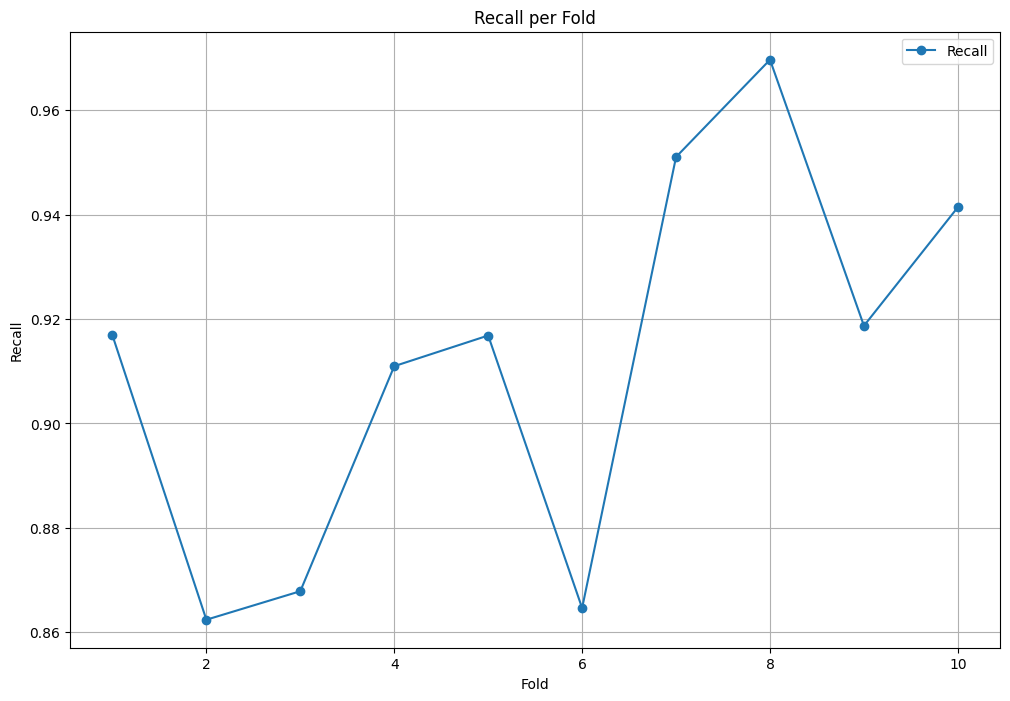

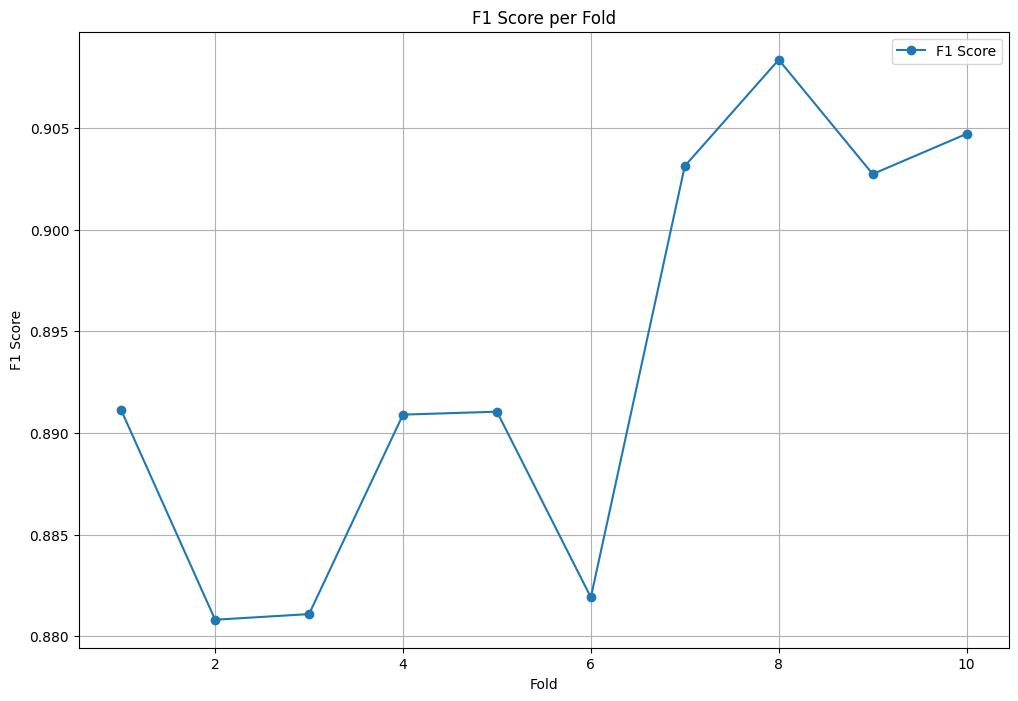

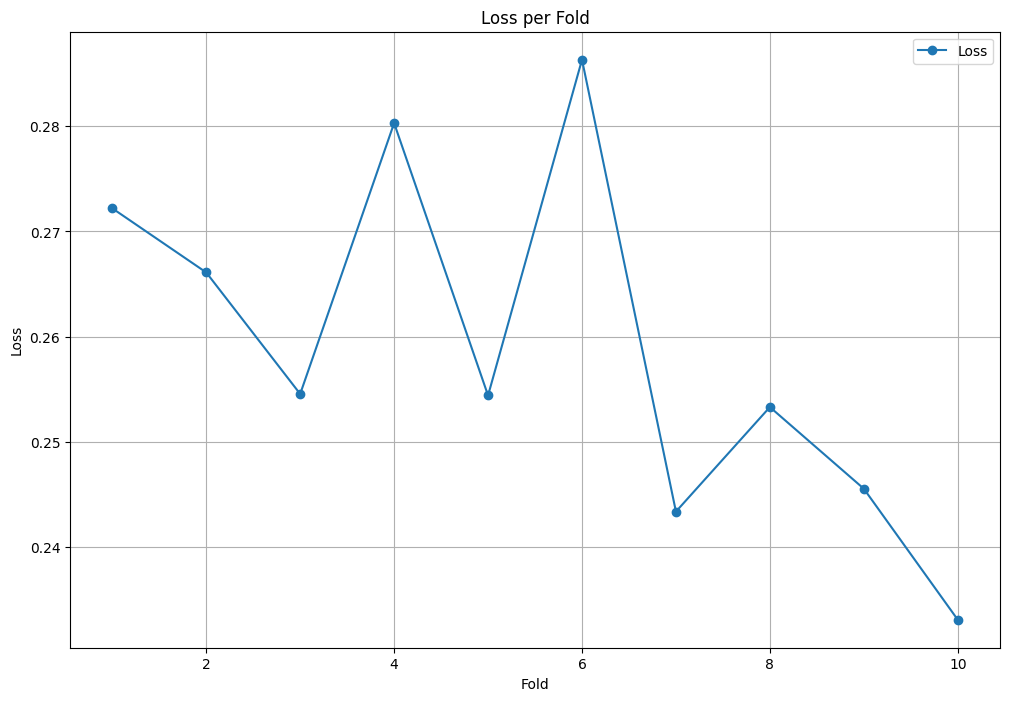

In [ ]:
import matplotlib.pyplot as plt

# Visualisasi metrik per fold
folds = range(1, 11)  # Untuk 10 fold

# Akurasi per fold
plt.figure(figsize=(12, 8))
plt.plot(folds, accuracies, marker='o', label='Accuracy')
plt.title('Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()

# Recall per fold
plt.figure(figsize=(12, 8))
plt.plot(folds, recalls, marker='o', label='Recall')
plt.title('Recall per Fold')
plt.xlabel('Fold')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.show()

# F1 Score per fold
plt.figure(figsize=(12, 8))
plt.plot(folds, f1_scores, marker='o', label='F1 Score')
plt.title('F1 Score per Fold')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.show()

# Loss per fold
plt.figure(figsize=(12, 8))
plt.plot(folds, losses, marker='o', label='Loss')
plt.title('Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Matrix Confusion Old

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


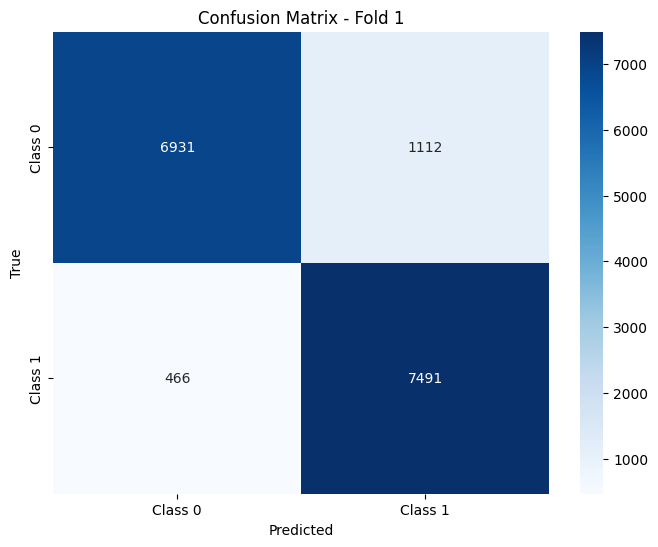

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


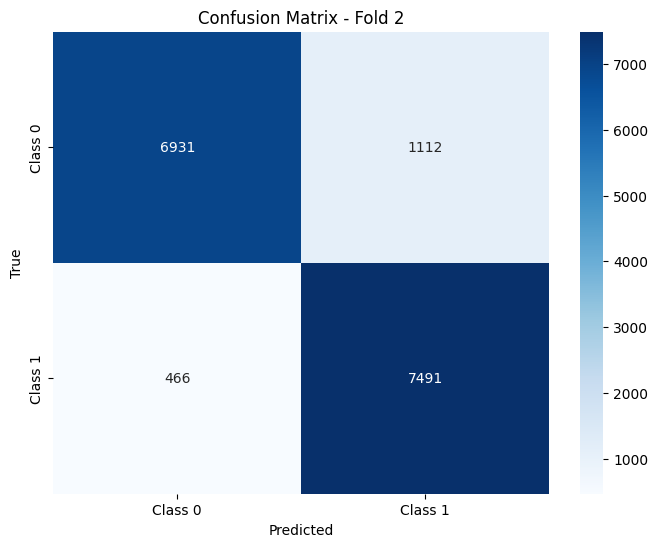

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


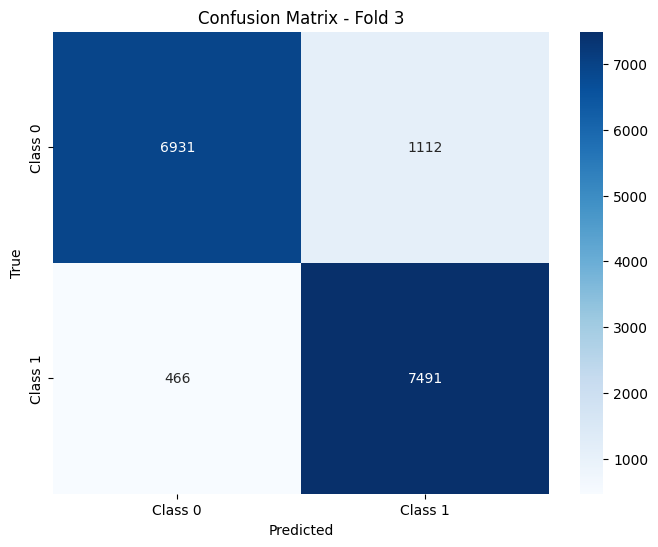

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


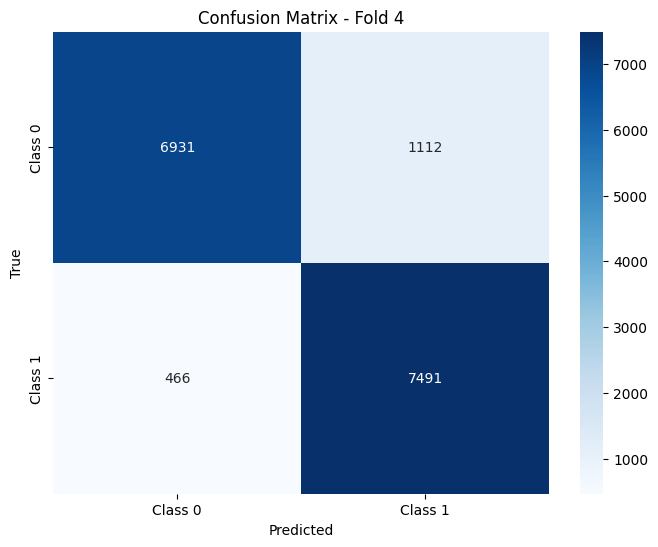

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


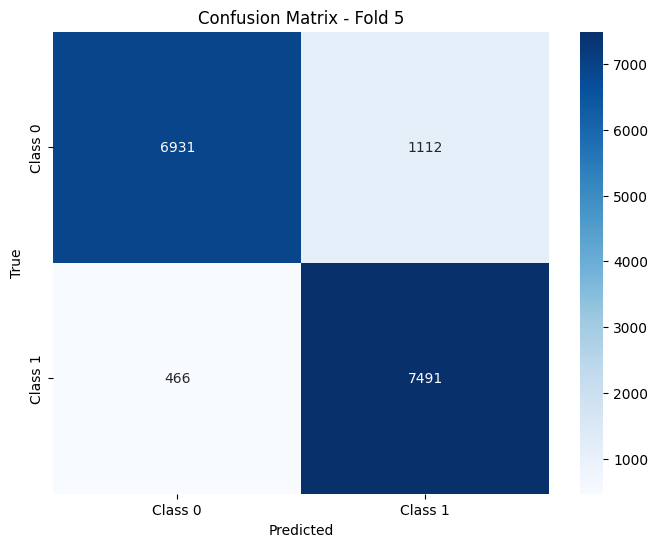

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


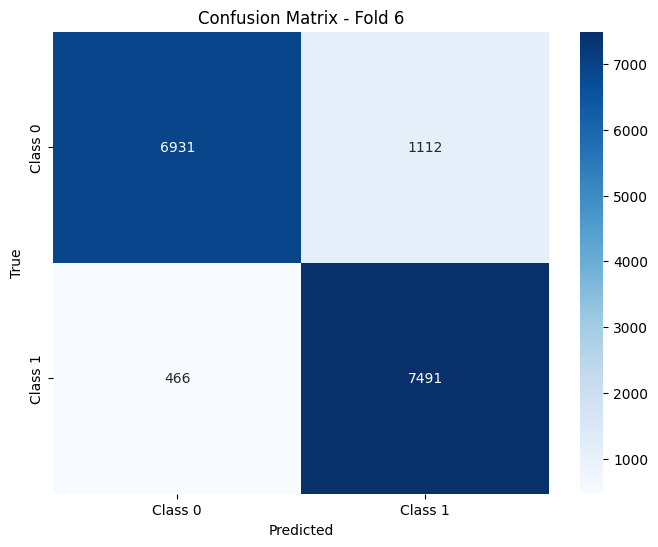

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


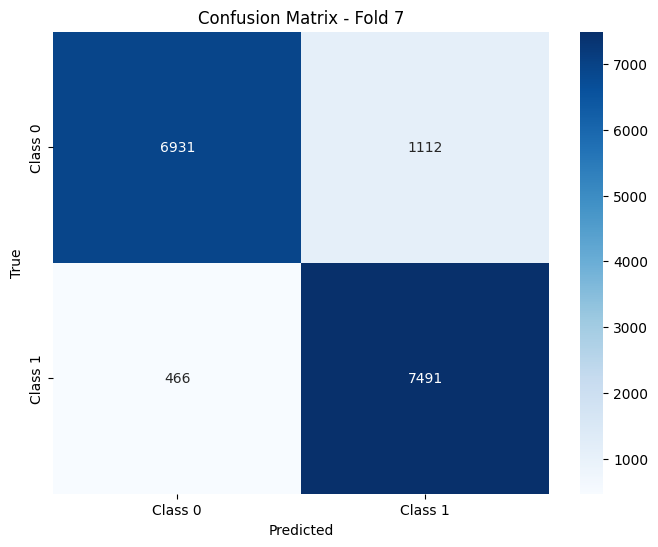

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


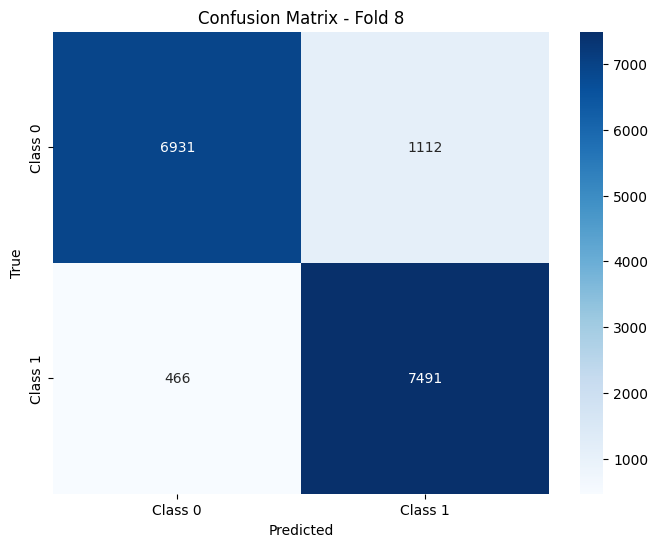

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


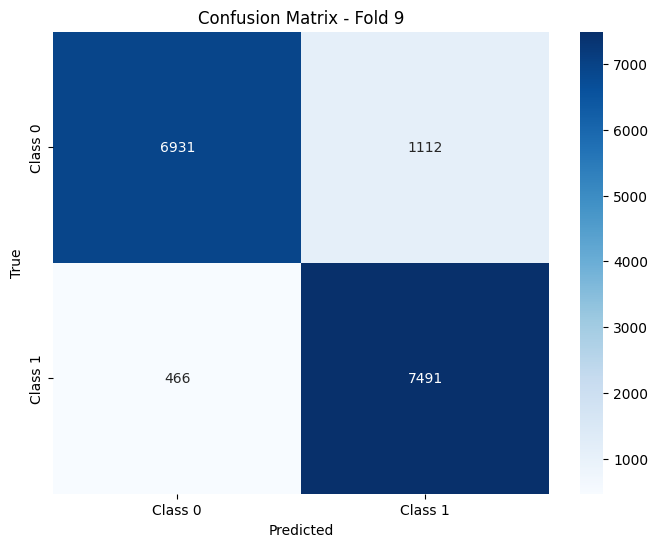

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


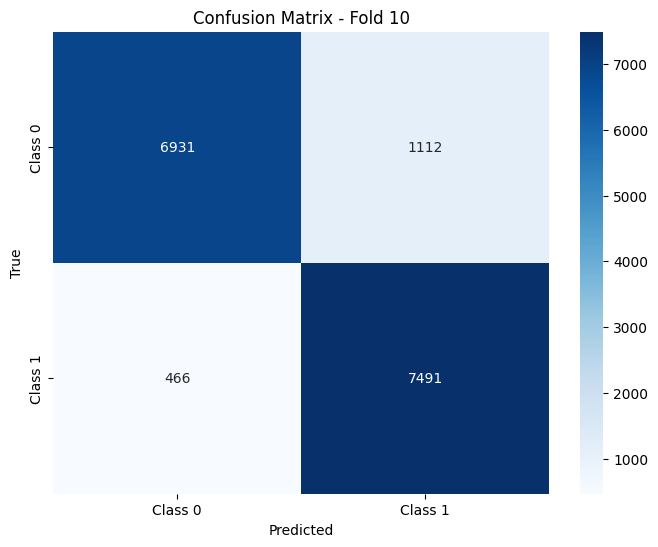

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualisasi Confusion Matrix per fold
for fold_no, history in enumerate(history_list, start=1):
    # Prediksi untuk fold tertentu
    y_pred = best_model.predict(X_val_fold) > 0.5  # Menggunakan threshold 0.5

    # Membuat confusion matrix
    cm = confusion_matrix(y_val_fold, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix - Fold {fold_no}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Matrix Confusion New

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


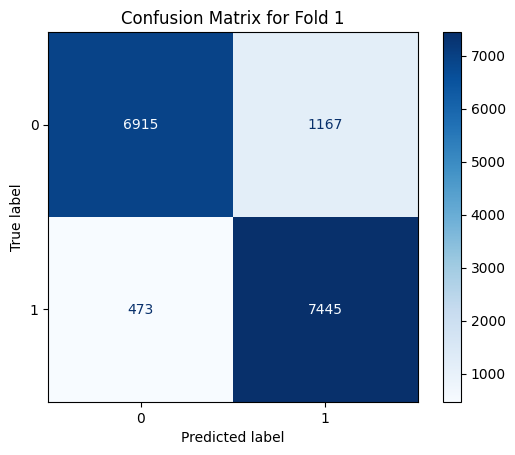

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


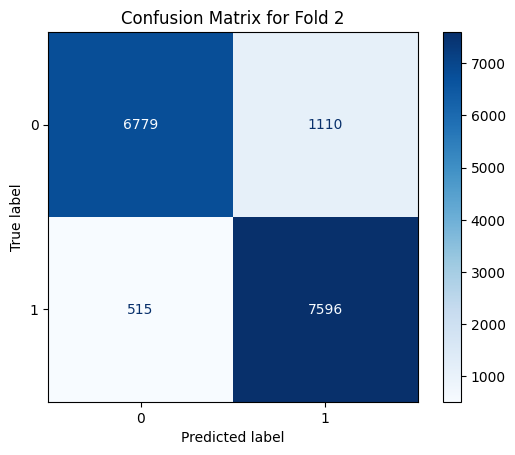

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


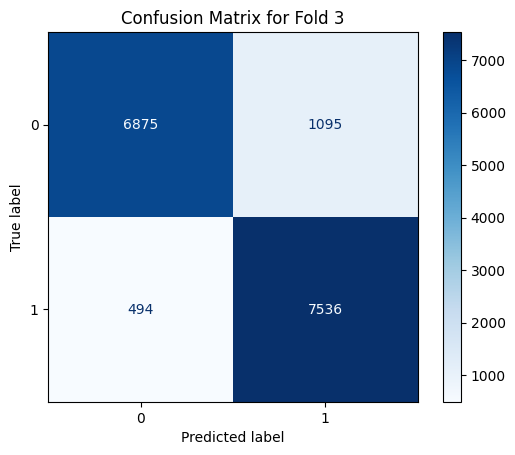

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


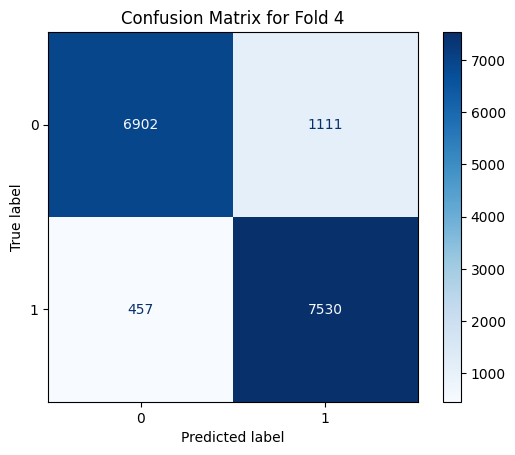

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


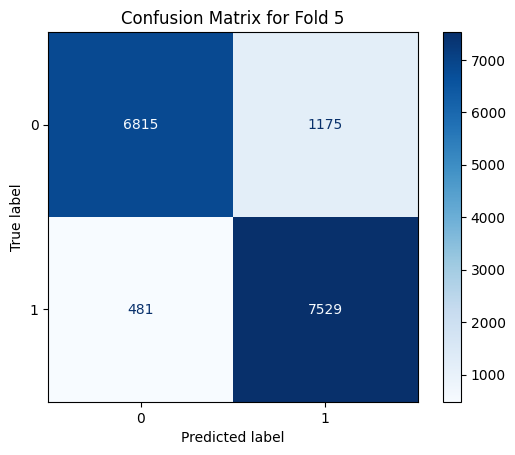

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


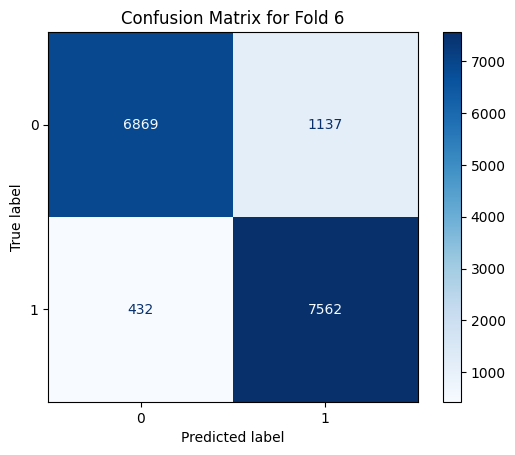

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


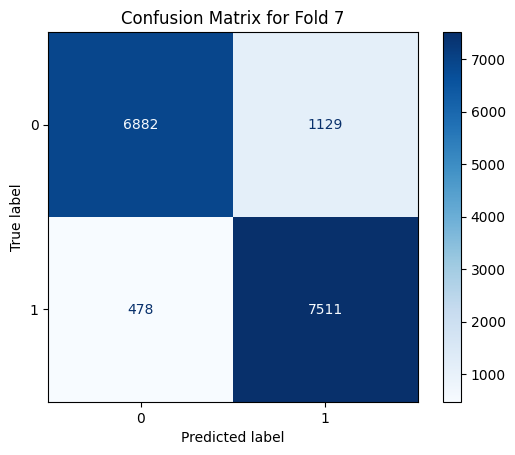

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


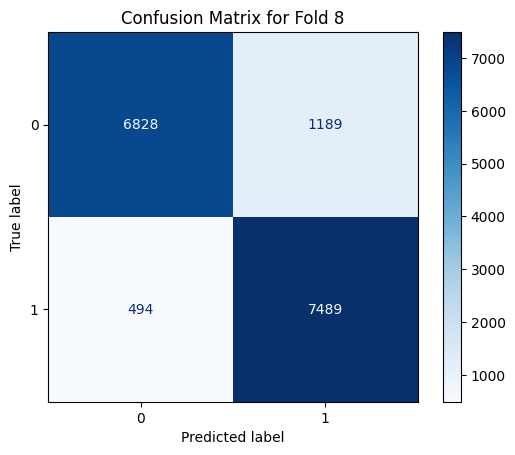

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


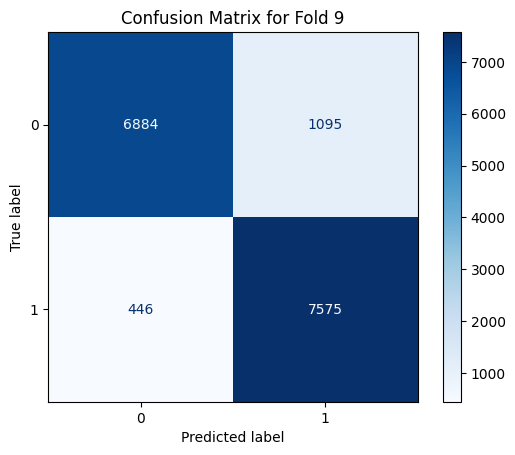

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


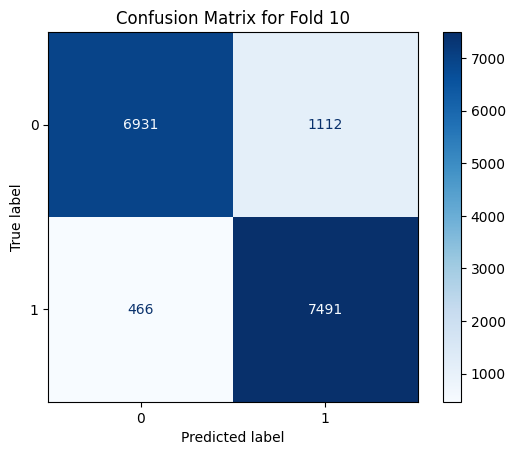

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fungsi untuk menampilkan confusion matrix
def plot_confusion_matrix(y_true, y_pred, fold_no):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.show()

# Visualisasi confusion matrix untuk setiap fold
fold_no = 1  # Reset fold number
for train_index, val_index in kf.split(X_train):
    # Prediksi pada data validasi
    X_val_fold = X_train[val_index]
    y_val_fold = y_train[val_index]
    y_pred = best_model.predict(X_val_fold) > 0.5  # Threshold 0.5

    # Plot confusion matrix
    plot_confusion_matrix(y_val_fold, y_pred, fold_no)

    fold_no += 1


Model Terbaik Di test ke Data Testing

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Testing Results:
Accuracy: 90.01%
Recall: 94.27%
F1 Score: 90.42%
ROC AUC: 0.97
Loss: 0.2357


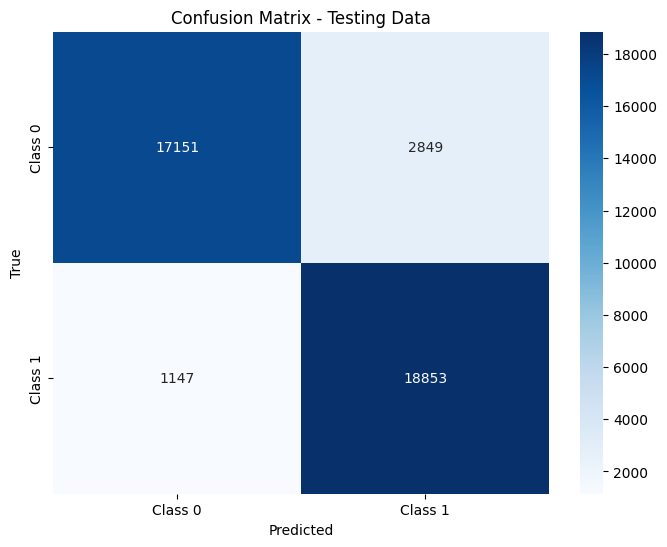

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Evaluasi pada data testing
# Prediksi probabilitas dan biner pada data testing
y_test_pred_proba = best_model.predict(X_test)  # Prediksi probabilitas
y_test_pred = (y_test_pred_proba > 0.5).astype(int)  # Prediksi biner dengan threshold 0.5

# Hitung metrik evaluasi
test_accuracy = accuracy_score(y_test, y_test_pred) * 100
test_recall = recall_score(y_test, y_test_pred) * 100
test_f1 = f1_score(y_test, y_test_pred) * 100
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

# Evaluasi loss
test_loss = best_model.evaluate(X_test, y_test, verbose=0)[0]

# Print hasil evaluasi
print(f"Testing Results:")
print(f"Accuracy: {test_accuracy:.2f}%")
print(f"Recall: {test_recall:.2f}%")
print(f"F1 Score: {test_f1:.2f}%")
print(f"ROC AUC: {test_roc_auc:.2f}")
print(f"Loss: {test_loss:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Testing Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Confusion matrix dari semua fold

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


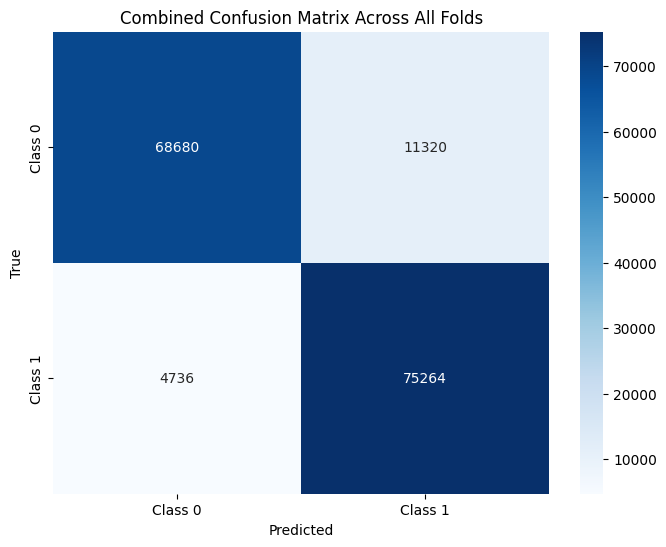

Confusion Matrix All Folds:
[[68680 11320]
 [ 4736 75264]]


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Inisialisasi matriks confusion gabungan
global_cm = np.zeros((2, 2), dtype=int)  # Asumsi binary classification (2x2 matrix)

for fold_no, (train_index, val_index) in enumerate(kf.split(X_train), start=1):
    # Data fold saat ini
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Prediksi pada data validasi fold ini
    y_val_pred = (best_model.predict(X_val_fold) > 0.5).astype(int)

    # Hitung matriks confusion untuk fold ini
    cm = confusion_matrix(y_val_fold, y_val_pred)

    # Tambahkan ke matriks confusion global
    global_cm += cm

# Visualisasi matriks confusion gabungan
plt.figure(figsize=(8, 6))
sns.heatmap(global_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Combined Confusion Matrix Across All Folds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print matriks confusion gabungan
print("Confusion Matrix All Folds:")
print(global_cm)